# Util

In [ ]:
# @title Utils
test = False

try: import gpytorch
except: 
    !pip install gpytorch
try: import botorch
except:
    !pip install botorch

import torch
import torch.optim as optim
from torch.optim import SGD
from tqdm import tqdm
import math
from math import exp
import itertools

import numpy as np
np.random.seed(1)

from matplotlib import cm
from matplotlib import pyplot as plt

import botorch
import gpytorch
from gpytorch.constraints import GreaterThan
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch import settings

def ground_truth(
    draw=False, n_dim=1, draw_3D=False, alpha=1, ls=math.sqrt(0.05)):

    if n_dim == 1:
        xs = np.linspace(0, 1, 1000)[:, None]
        mean = np.zeros(xs.shape[0])
        cov = kern_exp_quad_noard(xs, xs, alpha=alpha, ls=ls)
                                  
        np.random.seed(24)
        ys = sample_mvn(mean, cov, 1).squeeze()
        if draw: plt.plot(xs, ys, color='blue', alpha=0.1)
        return xs, ys
 
    elif n_dim == 2:

        grid = 20j
        xs = np.mgrid[0:1:grid, 0:1:grid].reshape(2,-1).T
        mean = np.zeros(xs.shape[0])
        cov = kern_exp_quad_noard(xs, xs, alpha=alpha, ls=ls)

        np.random.seed(5)
        ys = sample_mvn(mean, cov, 1).squeeze()

        if draw:
            xpts = np.linspace(0, 1, int(abs(grid)))
            ypts = np.linspace(0, 1, int(abs(grid)))
            X, Y = np.meshgrid(xpts, ypts)
            resol = int(abs(grid))
            Z = ys.reshape(resol, resol).T

            if draw_3D:
                fig, ax = plt.subplots(
                    figsize=(7,7), subplot_kw={"projection": "3d"})
                cf = ax.plot_surface(
                    X, Y, Z, cmap=cm.coolwarm, 
                    linewidth=0, antialiased=False)
                cbar = plt.colorbar(cf, fraction=0.046, pad=0.04)

            plt.figure(figsize=(7, 7))
            cf = plt.contourf(X, Y, Z, 40, cmap=cm.coolwarm, zorder=0)
            cbar = plt.colorbar(cf, fraction=0.046, pad=0.04)

        return xs, ys

    else: raise 

def p_loss(x):
    return torch.maximum(torch.abs(x - 0.5) - 0.5, torch.tensor([0]))

if test:
    j = 2
    n_dim = 2
    alpha = 1
    ls = math.sqrt(0.05)
    xs, ys = ground_truth(draw=True, n_dim=n_dim, alpha=alpha, ls=ls)
    plt.show()
    xs_new0 = xs[j, :][None, :]
    ys_new0, _ = gp_post(xs, ys, xs_new0, alpha=alpha, ls=ls)
    print('diff: ', ys_new0.item() -  ys[j].item())

In [ ]:
#@title SingleTaskGP

#!/usr/bin/env python3
# Copyright (c) Meta Platforms, Inc. and affiliates.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

r"""
Gaussian Process Regression models based on GPyTorch models.

These models are often a good starting point and are further documented in the
tutorials.

`SingleTaskGP`, `FixedNoiseGP`, and `HeteroskedasticSingleTaskGP` are all
single-task exact GP models, differing in how they treat noise. They use
relatively strong priors on the Kernel hyperparameters, which work best when
covariates are normalized to the unit cube and outcomes are standardized (zero
mean, unit variance).

These models all work in batch mode (each batch having its own hyperparameters).
When the training observations include multiple outputs, these models use
batching to model outputs independently.

These models all support multiple outputs. However, as single-task models,
`SingleTaskGP`, `FixedNoiseGP`, and `HeteroskedasticSingleTaskGP` should be
used only when the outputs are independent and all use the same training data.
If outputs are independent and outputs have different training data, use the
`ModelListGP`. When modeling correlations between outputs, use a multi-task
model like `MultiTaskGP`.
"""

from __future__ import annotations

from typing import Any, List, Optional, Union

import torch
from botorch import settings
from botorch.models.gpytorch import BatchedMultiOutputGPyTorchModel
from botorch.models.transforms.input import InputTransform
from botorch.models.transforms.outcome import Log, OutcomeTransform
from botorch.models.utils import fantasize as fantasize_flag, validate_input_scaling
from botorch.sampling.samplers import MCSampler
from gpytorch.constraints.constraints import GreaterThan
from gpytorch.distributions.multivariate_normal import MultivariateNormal
from gpytorch.kernels.matern_kernel import MaternKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.kernels import RBFKernel
from gpytorch.likelihoods.gaussian_likelihood import (
    _GaussianLikelihoodBase,
    FixedNoiseGaussianLikelihood,
    GaussianLikelihood,
)
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.likelihoods.noise_models import HeteroskedasticNoise
from gpytorch.means.constant_mean import ConstantMean
from gpytorch.means.mean import Mean
from gpytorch.mlls.noise_model_added_loss_term import NoiseModelAddedLossTerm
from gpytorch.models.exact_gp import ExactGP
from gpytorch.module import Module
from gpytorch.priors.smoothed_box_prior import SmoothedBoxPrior
from gpytorch.priors.torch_priors import GammaPrior
from torch import Tensor


MIN_INFERRED_NOISE_LEVEL = 1e-4


class SingleTaskGP(BatchedMultiOutputGPyTorchModel, ExactGP):
    r"""A single-task exact GP model.

    A single-task exact GP using relatively strong priors on the Kernel
    hyperparameters, which work best when covariates are normalized to the unit
    cube and outcomes are standardized (zero mean, unit variance).

    This model works in batch mode (each batch having its own hyperparameters).
    When the training observations include multiple outputs, this model will use
    batching to model outputs independently.

    Use this model when you have independent output(s) and all outputs use the
    same training data. If outputs are independent and outputs have different
    training data, use the ModelListGP. When modeling correlations between
    outputs, use the MultiTaskGP.

    Example:
        >>> train_X = torch.rand(20, 2)
        >>> train_Y = torch.sin(train_X).sum(dim=1, keepdim=True)
        >>> model = SingleTaskGP(train_X, train_Y)
    """

    def __init__(
        self,
        train_X: Tensor,
        train_Y: Tensor,
        likelihood: Optional[Likelihood] = None,
        covar_module: Optional[Module] = None,
        mean_module: Optional[Mean] = None,
        outcome_transform: Optional[OutcomeTransform] = None,
        input_transform: Optional[InputTransform] = None,
    ) -> None:
        r"""
        Args:
            train_X: A `batch_shape x n x d` tensor of training features.
            train_Y: A `batch_shape x n x m` tensor of training observations.
            likelihood: A likelihood. If omitted, use a standard
                GaussianLikelihood with inferred noise level.
            covar_module: The module computing the covariance (Kernel) matrix.
                If omitted, use a `MaternKernel`.
            mean_module: The mean function to be used. If omitted, use a
                `ConstantMean`.
            outcome_transform: An outcome transform that is applied to the
                training data during instantiation and to the posterior during
                inference (that is, the `Posterior` obtained by calling
                `.posterior` on the model will be on the original scale).
            input_transform: An input transform that is applied in the model's
                forward pass.
        """
        with torch.no_grad():
            transformed_X = self.transform_inputs(
                X=train_X, input_transform=input_transform
            )
        if outcome_transform is not None:
            train_Y, _ = outcome_transform(train_Y)
        self._validate_tensor_args(X=transformed_X, Y=train_Y)
        ignore_X_dims = getattr(self, "_ignore_X_dims_scaling_check", None)
        validate_input_scaling(
            train_X=transformed_X, train_Y=train_Y, ignore_X_dims=ignore_X_dims
        )
        self._set_dimensions(train_X=train_X, train_Y=train_Y)
        train_X, train_Y, _ = self._transform_tensor_args(X=train_X, Y=train_Y)
        if likelihood is None:
            # noise_prior = GammaPrior(1.1, 0.05)
            noise_prior = GammaPrior(concentration=0.5, rate=1)
            noise_prior_mode = (noise_prior.concentration - 1) / noise_prior.rate
            likelihood = GaussianLikelihood(
                noise_prior=noise_prior,
                batch_shape=self._aug_batch_shape,
                noise_constraint=GreaterThan(
                    MIN_INFERRED_NOISE_LEVEL,
                    transform=None,
                    initial_value=noise_prior_mode,
                ),
            )
        else:
            self._is_custom_likelihood = True
        ExactGP.__init__(self, train_X, train_Y, likelihood)
        if mean_module is None:
            mean_module = ConstantMean(batch_shape=self._aug_batch_shape)
        self.mean_module = mean_module
        if covar_module is None:
            covar_module = \
                ScaleKernel(
                    # MaternKernel(
                    #     nu=2.5,
                    #     ard_num_dims=transformed_X.shape[-1],
                    #     batch_shape=self._aug_batch_shape,
                    #     lengthscale_prior=GammaPrior(3.0, 6.0),),
                    RBFKernel(
                        ard_num_dims=transformed_X.shape[-1],
                        batch_shape=self._aug_batch_shape,
                        lengthscale_prior=GammaPrior(3.0, 6.0),),
                    batch_shape=self._aug_batch_shape,
                    outputscale_prior=GammaPrior(2.0, 0.15),
                )
            self._subset_batch_dict = {
                "likelihood.noise_covar.raw_noise": -2,
                "mean_module.raw_constant": -1,
                "covar_module.raw_outputscale": -1,
                "covar_module.base_kernel.raw_lengthscale": -3,
            }
        self.covar_module = covar_module
        # TODO: Allow subsetting of other covar modules
        if outcome_transform is not None:
            self.outcome_transform = outcome_transform
        if input_transform is not None:
            self.input_transform = input_transform
        self.to(train_X)

    def forward(self, x: Tensor) -> MultivariateNormal:
        if self.training:
            x = self.transform_inputs(x)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [ ]:
#@title GP Util

"""
Utilities for Gaussian process (GP) inference.
"""

import numpy as np
from scipy.linalg import solve_triangular
from scipy.spatial.distance import cdist
import itertools


def kern_exp_quad_ard(xmat1, xmat2, ls, alpha):
    """
    Exponentiated quadratic kernel function with
    dimensionwise lengthscales if ls is an ndarray.
    """
    xmat1 = np.expand_dims(xmat1, axis=1)
    xmat2 = np.expand_dims(xmat2, axis=0)
    diff = xmat1 - xmat2
    diff /= ls
    norm = np.sum(diff ** 2, axis=-1) / 2.0
    kern = alpha ** 2 * np.exp(-norm)
    return kern


def kern_exp_quad_ard_sklearn(xmat1, xmat2, ls, alpha):
    """
    Exponentiated quadratic kernel function with dimensionwise lengthscales if ls is an
    ndarray, based on scikit-learn implementation.
    """
    dists = cdist(xmat1 / ls, xmat2 / ls, metric='sqeuclidean')
    exp_neg_norm = np.exp(-.5 * dists)
    return alpha ** 2 * exp_neg_norm


def kern_exp_quad_ard_per(xmat1, xmat2, ls, alpha, pdims, period=2):
    """
    Exponentiated quadratic kernel function with
    - dimensionwise lengthscales if ls is an ndarray
    - periodic dimensions denoted by pdims. We assume that the period
    is 2.
    """
    xmat1 = np.expand_dims(xmat1, axis=1)
    xmat2 = np.expand_dims(xmat2, axis=0)
    diff = xmat1 - xmat2
    diff[..., pdims] = np.sin((np.pi * diff[..., pdims] / period) % (2 * np.pi))
    #diff[..., pdims] = np.cos( (np.pi/2) + (np.pi * diff[..., pdims] / period) )
    diff /= ls
    norm = np.sum(diff ** 2, axis=-1) / 2.0
    kern = alpha ** 2 * np.exp(-norm)

    return kern


def kern_exp_quad_noard(xmat1, xmat2, ls, alpha):
    """
    Exponentiated quadratic kernel function (aka squared exponential kernel aka
    RBF kernel).
    """
    kern = alpha ** 2 * kern_exp_quad_noard_noscale(xmat1, xmat2, ls)
    return kern


def kern_exp_quad_noard_noscale(xmat1, xmat2, ls):
    """
    Exponentiated quadratic kernel function (aka squared exponential kernel aka
    RBF kernel), without scale parameter.
    """
    distmat = squared_euc_distmat(xmat1, xmat2)
    norm = distmat / (2 * ls ** 2)
    exp_neg_norm = np.exp(-norm)
    return exp_neg_norm


def squared_euc_distmat(xmat1, xmat2, coef=1.0):
    """
    Distance matrix of squared euclidean distance (multiplied by coef) between
    points in xmat1 and xmat2.
    """
    return coef * cdist(xmat1, xmat2, 'sqeuclidean')


def kern_distmat(xmat1, xmat2, ls, alpha, distfn):
    """
    Kernel for a given distmat, via passed in distfn (which is assumed to be fn
    of xmat1 and xmat2 only).
    """
    distmat = distfn(xmat1, xmat2)
    kernmat = alpha ** 2 * np.exp(-distmat / (2 * ls ** 2))
    return kernmat


def kern_simple_list(xlist1, xlist2, ls, alpha, base_dist=5.0):
    """
    Kernel for two lists containing elements that can be compared for equality.
    K(a,b) = 1 + base_dist if a and b are equal and K(a,b) = base_dist otherwise.
    """
    distmat = simple_list_distmat(xlist1, xlist2)
    distmat = distmat + base_dist
    kernmat = alpha ** 2 * np.exp(-distmat / (2 * ls ** 2))
    return kernmat


def simple_list_distmat(xlist1, xlist2, weight=1.0, additive=False):
    """
    Return distance matrix containing zeros when xlist1[i] == xlist2[j] and 0 otherwise.
    """
    prod_list = list(itertools.product(xlist1, xlist2))
    len1 = len(xlist1)
    len2 = len(xlist2)
    try:
        binary_mat = np.array([x[0] != x[1] for x in prod_list]).astype(int)
    except:
        # For cases where comparison returns iterable of bools
        binary_mat = np.array([all(x[0] != x[1]) for x in prod_list]).astype(int)

    binary_mat = binary_mat.reshape(len1, len2)

    if additive:
        distmat = weight + binary_mat
    else:
        distmat = weight * binary_mat

    return distmat


def get_product_kernel(kernel_list, additive=False):
    """Given a list of kernel functions, return product kernel."""

    def product_kernel(x1, x2, ls, alpha):
        """Kernel returning elementwise-product of kernel matrices from kernel_list."""
        mat_prod = kernel_list[0](x1, x2, ls, 1.0)
        for kernel in kernel_list[1:]:
            if additive:
                mat_prod = mat_prod + kernel(x1, x2, ls, 1.0)
            else:
                mat_prod = mat_prod * kernel(x1, x2, ls, 1.0)
        mat_prod = alpha ** 2 * mat_prod
        return mat_prod

    return product_kernel


def get_cholesky_decomp(k11_nonoise, sigma, psd_str):
    """Return cholesky decomposition."""
    if psd_str == 'try_first':
        k11 = k11_nonoise + sigma ** 2 * np.eye(k11_nonoise.shape[0])
        try:
            return stable_cholesky(k11, False)
        except np.linalg.linalg.LinAlgError:
            return get_cholesky_decomp(k11_nonoise, sigma, 'project_first')
    elif psd_str == 'project_first':
        k11_nonoise = project_symmetric_to_psd_cone(k11_nonoise)
        return get_cholesky_decomp(k11_nonoise, sigma, 'is_psd')
    elif psd_str == 'is_psd':
        k11 = k11_nonoise + sigma ** 2 * np.eye(k11_nonoise.shape[0])
        return stable_cholesky(k11)


def stable_cholesky(mmat, make_psd=True, verbose=False):
    """Return a 'stable' cholesky decomposition of mmat."""
    if mmat.size == 0:
        return mmat
    try:
        lmat = np.linalg.cholesky(mmat)
    except np.linalg.linalg.LinAlgError as e:
        if not make_psd:
            raise e
        diag_noise_power = -11
        max_mmat = np.diag(mmat).max()
        diag_noise = np.diag(mmat).max() * 1e-11
        break_loop = False
        while not break_loop:
            try:
                lmat = np.linalg.cholesky(
                    mmat + ((10 ** diag_noise_power) * max_mmat) * np.eye(mmat.shape[0])
                )
                break_loop = True
            except np.linalg.linalg.LinAlgError:
                if diag_noise_power > -9:
                    if verbose:
                        print(
                            '\t*stable_cholesky failed with '
                            'diag_noise_power=%d.' % (diag_noise_power)
                        )
                diag_noise_power += 1
            if diag_noise_power >= 5:
                print('\t*stable_cholesky failed: added diag noise = %e' % (diag_noise))
    return lmat


def project_symmetric_to_psd_cone(mmat, is_symmetric=True, epsilon=0):
    """Project symmetric matrix mmat to the PSD cone."""
    if is_symmetric:
        try:
            eigvals, eigvecs = np.linalg.eigh(mmat)
        except np.linalg.LinAlgError:
            print('\tLinAlgError encountered with np.eigh. Defaulting to eig.')
            eigvals, eigvecs = np.linalg.eig(mmat)
            eigvals = np.real(eigvals)
            eigvecs = np.real(eigvecs)
    else:
        eigvals, eigvecs = np.linalg.eig(mmat)
    clipped_eigvals = np.clip(eigvals, epsilon, np.inf)
    return (eigvecs * clipped_eigvals).dot(eigvecs.T)


def solve_lower_triangular(amat, b):
    """Solves amat*x=b when amat is lower triangular."""
    return solve_triangular_base(amat, b, lower=True)


def solve_upper_triangular(amat, b):
    """Solves amat*x=b when amat is upper triangular."""
    return solve_triangular_base(amat, b, lower=False)


def solve_triangular_base(amat, b, lower):
    """Solves amat*x=b when amat is a triangular matrix."""
    if amat.size == 0 and b.shape[0] == 0:
        return np.zeros((b.shape))
    else:
        return solve_triangular(amat, b, lower=lower)

def sample_mvn(mu, covmat, nsamp):
    """
    Sample from multivariate normal distribution with mean mu and covariance
    matrix covmat.
    """
    mu = mu.reshape(-1)
    ndim = len(mu)
    lmat = stable_cholesky(covmat)
    umat = np.random.normal(size=(ndim, nsamp))
    return lmat.dot(umat).T + mu

def gp_post(x_train, y_train, x_pred, ls, alpha, full_cov=True):
    """Compute parameters of GP posterior"""
    k11_nonoise = kern_exp_quad_noard(x_train, x_train, alpha=alpha, ls=ls)
    lmat = get_cholesky_decomp(k11_nonoise, 1e-2, 'try_first')
    smat = solve_upper_triangular(lmat.T, solve_lower_triangular(lmat, y_train))
    k21 = kern_exp_quad_noard(x_pred, x_train, alpha=alpha, ls=ls)
    mu2 = k21.dot(smat)
    k22 = kern_exp_quad_noard(x_pred, x_pred, alpha=alpha, ls=ls)
    vmat = solve_lower_triangular(lmat, k21.T)
    k2 = k22 - vmat.T.dot(vmat)
    if full_cov is False:
        k2 = np.sqrt(np.diag(k2))
    return mu2, k2

# def query(x):
#     assert len(x.shape) == 2

#     xs, ys = ground_truth(n_dim=x.shape[1])
#     xs_new = np.concatenate([xs, x], axis=0)

#     print('xs: ', xs.shape)
#     print('xs_new: ', xs_new.shape)

#     mean_new = np.zeros(xs_new.shape[0])
#     gram_new = np.array(cov_matrix(xs_new))

#     if x.shape[1] == 1: np.random.seed(62)
#     elif x.shape[1] == 2: np.random.seed(14)

#     ys_new = sample_mvn(mean_new, gram_new, 1).squeeze()

#     return ys_new[-x.shape[0]:]

# # We will use the simplest form of GP model, exact inference
# class ExactGPModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# def rbf_kernel(x1, x2, variance = 0.05):
#     return exp(-1 * (((x1-x2)**2).sum()) / (2*variance))

# def cov_matrix(xs):
#     return [[rbf_kernel(x1,x2) for x2 in xs] for x1 in xs]


In [ ]:
#@title ModelInit

def init_model(n_dim):
    train = False
    noise = False

    alpha = 1
    ls = math.sqrt(0.05)

    xs, ys = ground_truth(draw=False, n_dim=n_dim, alpha=alpha, ls=ls)

    train_x = np.linspace(0, 1, 4).reshape(-1, n_dim)

    if n_dim == 1: 
        train_x = np.linspace(0, 1, 4).reshape(-1, n_dim)
        x_start = np.array([[0.2]])
    elif n_dim == 2: 
        train_x = np.mgrid[0:1:4j, 0:1:4j].reshape(2,-1).T
        x_start = np.array([[0.4, 0.4]])
    else: raise

    train_x = np.concatenate([train_x, x_start], axis=0)
    train_y, _  = gp_post(
        x_train=xs, y_train=ys, x_pred=train_x, alpha=alpha, ls=ls)

    train_x = torch.tensor(train_x, dtype=torch.float64)
    train_y = torch.tensor(train_y, dtype=torch.float64)
    train_y = train_y[:, None]

    model = SingleTaskGP(train_X=train_x, train_Y=train_y)
    if noise:
        model.likelihood.noise_covar.register_constraint(
            "raw_noise", GreaterThan(1e-6))

    mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
    mll = mll.to(train_x)

    if not train:
        model.covar_module.base_kernel.lengthscale = ls
        model.covar_module.outputscale = alpha
        model.likelihood.noise = 1e-10
    else:

        optimizer = SGD([{'params': model.parameters()}], lr=0.05)
        NUM_EPOCHS = 10000

        model.train()

        for epoch in range(NUM_EPOCHS):
            optimizer.zero_grad()
            # forward pass through the model to 
            # obtain the output MultivariateNormal
            output = model(train_x)
            # Compute negative marginal log likelihood
            loss = - mll(output, model.train_targets)
            # back prop gradients
            loss.backward()
            # print every 200 iterations
            if (epoch + 1) % 200 == 0:
                print(
                    f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.10f} "
                    f"lengthscale: {model.covar_module.base_kernel.lengthscale.item():>4.10f} " 
                    f"outputscale: {model.covar_module.outputscale.item():>4.10f} " 
                    f"noise: {model.likelihood.noise.item():>4.10f}" 
                )
                        
            optimizer.step()

    # set model (and likelihood)
    model.eval()

    return model, train_x, train_y

def draw_posterior():
    n_dim = 2

    model, train_x, train_y = init_model(n_dim=n_dim)

    grid = 20j
    test_x = np.mgrid[0:1:grid, 0:1:grid].reshape(2,-1).T

    alpha = 1
    ls = math.sqrt(0.05)

    test_y, _= gp_post(x_train=train_x, y_train=train_y, x_pred=test_x, alpha=alpha, ls=ls)


    xpts = np.linspace(0, 1, int(abs(grid)))
    ypts = np.linspace(0, 1, int(abs(grid)))
    X, Y = np.meshgrid(xpts, ypts)
    resol = int(abs(grid))
    Z = test_y.reshape(resol, resol).T

    plt.figure(figsize=(7, 7))
    cf = plt.contourf(X, Y, Z, 40, cmap=cm.coolwarm, zorder=0)
    cbar = plt.colorbar(cf, fraction=0.046, pad=0.04)

    plt.scatter(train_x[:, 0], train_x[:, 1], marker='*', color='black')

    # prev_x = torch.tensor([[0.2, 0.6]])

    # plt.hlines(prev_x[0, 1] - 0.1, 0, 1, linestyle='--')
    # plt.hlines(prev_x[0, 1] + 0.1, 0, 1, linestyle='--')
    # plt.vlines(prev_x[0, 0] - 0.1, 0, 1, linestyle='--')
    # plt.vlines(prev_x[0, 0] + 0.1, 0, 1, linestyle='--')


# 1D Case

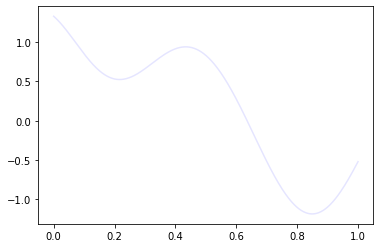

In [ ]:
model, train_x, train_y = init_model(n_dim=1)

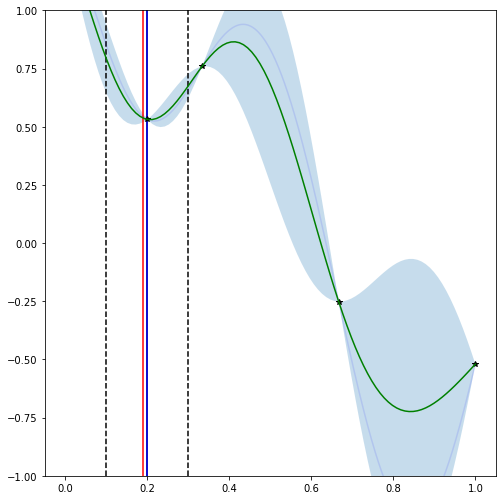

In [ ]:
#@title Naive Myopic
prev_x = 0.2
temp = []
for x0 in torch.linspace(prev_x-0.1, prev_x+0.1, 10):
    x0 = x0.reshape(1)
    p_y0_on_x0_D0 = model.posterior(x0)

    p_f_on_D1 = model.condition_on_observations(
        x0, p_y0_on_x0_D0.mean
    )
    
    for a in torch.linspace(x0.item()-0.1, x0.item()+0.1, 10):
        a = a.reshape(1)
        p_y1_a_D1 = p_f_on_D1.posterior(a)
        temp.append([x0, a, p_y1_a_D1.mean])

temp = torch.tensor(temp)
best = torch.argmin(temp, dim=0)[2].item()
best_x, best_a, best_hes = temp[best].numpy().tolist()

plt.figure(figsize=(7, 7))
ground_truth(draw=True)

plt.vlines(prev_x, -1, 1, color='black')
plt.vlines(prev_x-0.1, -1, 1, color='black', linestyle='--')
plt.vlines(prev_x+0.1, -1, 1, color='black', linestyle='--')

plt.vlines(best_x, -1, 1, color='red')
plt.vlines(best_a, -1, 1, color='blue')

plt.plot(
    train_x.cpu().numpy(), 
    train_y.cpu().numpy(), 
    'k*')

# compute posterior
test_x = torch.linspace(0, 1, 100)
posterior = model.posterior(test_x)
test_y = posterior.mean
lower, upper = posterior.mvn.confidence_region()

plt.plot(
    test_x.cpu().detach().numpy(), 
    test_y.cpu().detach().numpy(), 
    'green')

plt.fill_between(
    test_x.cpu().detach().numpy(), 
    lower.cpu().detach().numpy(), 
    upper.cpu().detach().numpy(), 
    alpha=0.25)

plt.tight_layout()
plt.ylim(-1, 1)

plt.show()

100%|██████████| 10/10 [00:20<00:00,  2.08s/it]


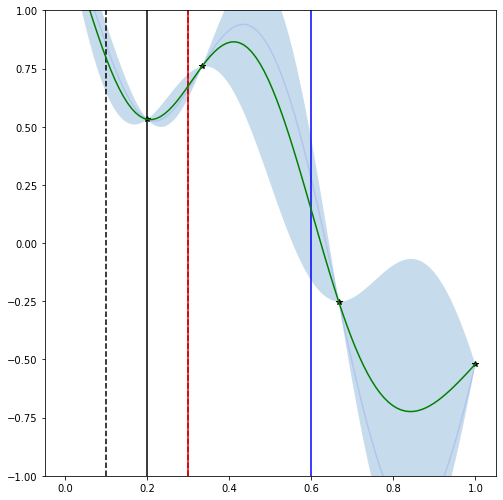

In [ ]:
#@title Naive 3 steps

prev_x = 0.2
temp = []
for x0 in tqdm(torch.linspace(prev_x-0.1, prev_x+0.1, 10)):
    x0 = x0.reshape(1)
    p_y0_on_x0_D0 = model.posterior(x0)
    p_f_on_D1 = model.condition_on_observations(
        x0, p_y0_on_x0_D0.mean
    )

    for x1 in torch.linspace(x0.item()-0.1, x0.item()+0.1, 10):
        x1 = x1.reshape(1)
        p_y1_on_x1_D1 = p_f_on_D1.posterior(x1)
        p_f_on_D2 = p_f_on_D1.condition_on_observations(
            x1, p_y1_on_x1_D1.mean
        )

        for x2 in torch.linspace(x1.item()-0.1, x1.item()+0.1, 10):
            x2 = x2.reshape(1)
            p_y2_on_x2_D2 = p_f_on_D2.posterior(x2)
            p_f_on_D3 = p_f_on_D2.condition_on_observations(
                x2, p_y2_on_x2_D2.mean
            )

            for a in torch.linspace(x2.item()-0.1, x2.item()+0.1, 10):
                a = a.reshape(1)
                p_y3_a_D3 = p_f_on_D3.posterior(a)
                temp.append([x0, a, p_y3_a_D3.mean])

temp = torch.tensor(temp)
best = torch.argmin(temp, dim=0)[2].item()
best_x, best_a, best_hes = temp[best].numpy().tolist()

plt.figure(figsize=(7, 7))
ground_truth(draw=True)

plt.vlines(prev_x, -1, 1, color='black')
plt.vlines(prev_x-0.1, -1, 1, color='black', linestyle='--')
plt.vlines(prev_x+0.1, -1, 1, color='black', linestyle='--')

plt.vlines(best_x, -1, 1, color='red')
plt.vlines(best_a, -1, 1, color='blue')

plt.plot(
    train_x.cpu().numpy(), 
    train_y.cpu().numpy(), 
    'k*')

# compute posterior
test_x = torch.linspace(0, 1, 100)
posterior = model.posterior(test_x)
test_y = posterior.mean
lower, upper = posterior.mvn.confidence_region()

plt.plot(
    test_x.cpu().detach().numpy(), 
    test_y.cpu().detach().numpy(), 
    'green')

plt.fill_between(
    test_x.cpu().detach().numpy(), 
    lower.cpu().detach().numpy(), 
    upper.cpu().detach().numpy(), 
    alpha=0.25)

plt.tight_layout()
plt.ylim(-1, 1)

plt.show()

100%|██████████| 10/10 [04:12<00:00, 25.28s/it]


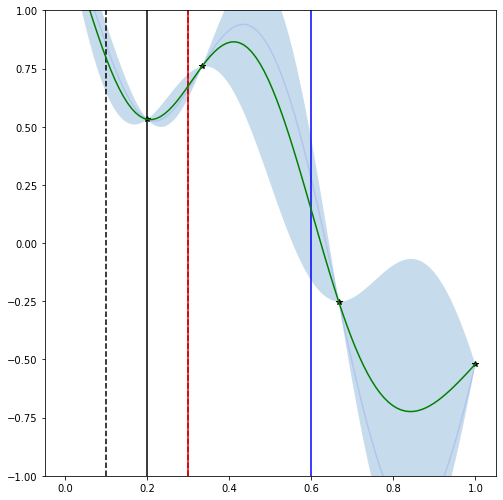

In [ ]:
#@title Joint 3 Steps

def compute_ehig(x0, x1, x2, a):
    p_y0_on_x0_D0 = model.posterior(x0)
    p_f_on_D1 = model.condition_on_observations(
        x0, p_y0_on_x0_D0.mean
    )

    p_y1_on_x1_D1 = p_f_on_D1.posterior(x1)
    p_f_on_D2 = p_f_on_D1.condition_on_observations(
        x1, p_y1_on_x1_D1.mean
    )

    p_y2_on_x2_D2 = p_f_on_D2.posterior(x2)
    p_f_on_D3 = p_f_on_D2.condition_on_observations(
        x2, p_y2_on_x2_D2.mean
    )

    p_y3_a_D3 = p_f_on_D3.posterior(a)

    ehig = p_y3_a_D3.mean

    return ehig

prev_x = 0.2
temp = []
for x0 in tqdm(torch.linspace(prev_x-0.1, prev_x+0.1, 10)):
    if not 0 <= x0.item() <= 1: continue
    x0 = x0.reshape(1)
    for x1 in torch.linspace(x0.item()-0.1, x0.item()+0.1, 10):
        if not 0 <= x1.item() <= 1: continue
        x1 = x1.reshape(1)
        for x2 in torch.linspace(x1.item()-0.1, x1.item()+0.1, 10):
            if not 0 <= x2.item() <= 1: continue
            x2 = x2.reshape(1)
            for a in torch.linspace(x2.item()-0.1, x2.item()+0.1, 10):
                if not 0 <= a.item() <= 1: continue
                a = a.reshape(1)

                ehig = compute_ehig(x0, x1, x2, a)

                temp.append([x0, a, ehig])

temp = torch.tensor(temp)
best = torch.argmin(temp, dim=0)[2].item()
best_x, best_a, best_hes = temp[best].numpy().tolist()

plt.figure(figsize=(7, 7))
ground_truth(draw=True)

plt.vlines(prev_x, -1, 1, color='black')
plt.vlines(prev_x-0.1, -1, 1, color='black', linestyle='--')
plt.vlines(prev_x+0.1, -1, 1, color='black', linestyle='--')

plt.vlines(best_x, -1, 1, color='red')
plt.vlines(best_a, -1, 1, color='blue')

plt.plot(
    train_x.cpu().numpy(), 
    train_y.cpu().numpy(), 
    'k*')

# compute posterior
test_x = torch.linspace(0, 1, 100)
posterior = model.posterior(test_x)
test_y = posterior.mean
lower, upper = posterior.mvn.confidence_region()

plt.plot(
    test_x.cpu().detach().numpy(), 
    test_y.cpu().detach().numpy(), 
    'green')

plt.fill_between(
    test_x.cpu().detach().numpy(), 
    lower.cpu().detach().numpy(), 
    upper.cpu().detach().numpy(), 
    alpha=0.25)

plt.tight_layout()
plt.ylim(-1, 1)

plt.show()

100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


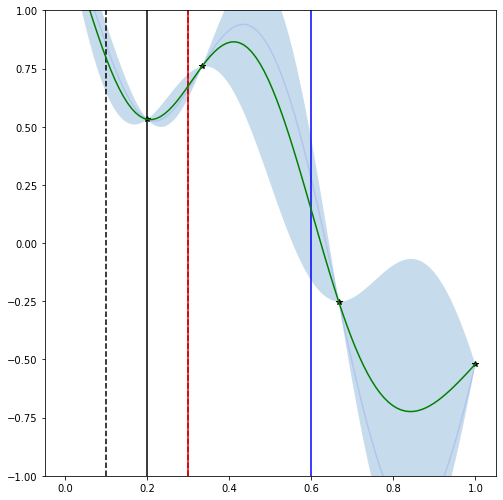

In [ ]:
#@title Joint 3 Steps with sigmoid

def compute_ehig(x0, x1, x2, a):
    '''
    x0 to a: unconstraint optimization parameters
    '''
    x0 = torch.sigmoid(x0) * 0.2 + (prev_x - 0.1)

    x1 = torch.sigmoid(x1) * 0.2 + (x0 - 0.1)

    x2 = torch.sigmoid(x2) * 0.2 + (x1 - 0.1)
    # x2 = x2 * 2

    a = torch.sigmoid(a) * 0.2 + (x2 - 0.1)
    # a = a * 2

    x0 = x0.reshape(1)
    x1 = x1.reshape(1)
    x2 = x2.reshape(1)
    a = a.reshape(1)

    p_y0_on_x0_D0 = model.posterior(x0)
    p_f_on_D1 = model.condition_on_observations(
        x0, p_y0_on_x0_D0.mean
    )

    p_y1_on_x1_D1 = p_f_on_D1.posterior(x1)
    p_f_on_D2 = p_f_on_D1.condition_on_observations(
        x1, p_y1_on_x1_D1.mean
    )

    p_y2_on_x2_D2 = p_f_on_D2.posterior(x2)
    p_f_on_D3 = p_f_on_D2.condition_on_observations(
        x2, p_y2_on_x2_D2.mean
    )

    p_y3_a_D3 = p_f_on_D3.posterior(a)

    ehig = p_y3_a_D3.mean

    return x0, a, ehig

prev_x = 0.2
temp = []
for x0 in tqdm(torch.linspace(-10, 10, 2)):
    for x1 in torch.linspace(-10, 10, 2):
        for x2 in torch.linspace(-10, 10, 2):
            for a in torch.linspace(-10, 10, 2):
                x0_, a_, ehig = compute_ehig(x0, x1, x2, a)

                temp.append([x0_, a_, ehig])

temp = torch.tensor(temp)
best = torch.argmin(temp, dim=0)[2].item()
best_x, best_a, best_hes = temp[best].numpy().tolist()

plt.figure(figsize=(7, 7))
ground_truth(draw=True)

plt.vlines(prev_x, -1, 1, color='black')
plt.vlines(prev_x-0.1, -1, 1, color='black', linestyle='--')
plt.vlines(prev_x+0.1, -1, 1, color='black', linestyle='--')

plt.vlines(best_x, -1, 1, color='red')
plt.vlines(best_a, -1, 1, color='blue')

plt.plot(
    train_x.cpu().numpy(), 
    train_y.cpu().numpy(), 
    'k*')

# compute posterior
test_x = torch.linspace(0, 1, 100)
posterior = model.posterior(test_x)
test_y = posterior.mean
lower, upper = posterior.mvn.confidence_region()

plt.plot(
    test_x.cpu().detach().numpy(), 
    test_y.cpu().detach().numpy(), 
    'green')

plt.fill_between(
    test_x.cpu().detach().numpy(), 
    lower.cpu().detach().numpy(), 
    upper.cpu().detach().numpy(), 
    alpha=0.25)

plt.tight_layout()
plt.ylim(-1, 1)

plt.show()

  1%|          | 6/1000 [00:00<00:38, 25.52it/s]

0.6987092864477195 tensor([4.9602], requires_grad=True) tensor([5.5624], requires_grad=True) tensor([1.0280], requires_grad=True) tensor([1.3378], requires_grad=True)


 10%|█         | 105/1000 [00:03<00:33, 26.38it/s]

0.1532433692144186 tensor([8.8435], requires_grad=True) tensor([9.4419], requires_grad=True) tensor([5.2694], requires_grad=True) tensor([5.4931], requires_grad=True)


 20%|██        | 204/1000 [00:07<00:30, 26.34it/s]

0.14631801903649638 tensor([9.7084], requires_grad=True) tensor([10.3064], requires_grad=True) tensor([6.1588], requires_grad=True) tensor([6.3771], requires_grad=True)


 31%|███       | 306/1000 [00:11<00:25, 26.71it/s]

0.1442396287919783 tensor([10.2622], requires_grad=True) tensor([10.8602], requires_grad=True) tensor([6.7207], requires_grad=True) tensor([6.9373], requires_grad=True)


 40%|████      | 405/1000 [00:15<00:22, 26.59it/s]

0.14330343498940964 tensor([10.6734], requires_grad=True) tensor([11.2713], requires_grad=True) tensor([7.1358], requires_grad=True) tensor([7.3515], requires_grad=True)


 50%|█████     | 504/1000 [00:18<00:18, 26.55it/s]

0.14279040765671483 tensor([11.0021], requires_grad=True) tensor([11.5998], requires_grad=True) tensor([7.4668], requires_grad=True) tensor([7.6820], requires_grad=True)


 61%|██████    | 606/1000 [00:22<00:14, 27.07it/s]

0.14247503391294386 tensor([11.2771], requires_grad=True) tensor([11.8747], requires_grad=True) tensor([7.7432], requires_grad=True) tensor([7.9581], requires_grad=True)


 70%|███████   | 705/1000 [00:26<00:11, 26.64it/s]

0.14226527242169007 tensor([11.5141], requires_grad=True) tensor([12.1118], requires_grad=True) tensor([7.9813], requires_grad=True) tensor([8.1960], requires_grad=True)


 80%|████████  | 804/1000 [00:29<00:07, 27.47it/s]

0.14211748531294544 tensor([11.7231], requires_grad=True) tensor([12.3207], requires_grad=True) tensor([8.1910], requires_grad=True) tensor([8.4056], requires_grad=True)


 91%|█████████ | 906/1000 [00:33<00:03, 26.96it/s]

0.14200893665113595 tensor([11.9105], requires_grad=True) tensor([12.5081], requires_grad=True) tensor([8.3790], requires_grad=True) tensor([8.5934], requires_grad=True)


100%|██████████| 1000/1000 [00:37<00:00, 26.61it/s]


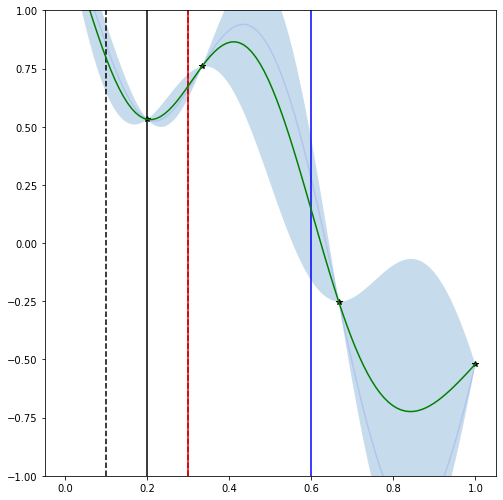

In [ ]:
#@title Joint 3 Steps with sigmoid and adam

def compute_ehig(x0, x1, x2, a):
    '''
    x0 to a: unconstraint optimization parameters
    '''

    x0 = torch.sigmoid(x0) * 0.2 + (prev_x - 0.1)

    x1 = torch.sigmoid(x1) * 0.2 + (x0 - 0.1)

    x2 = torch.sigmoid(x2) * 0.2 + (x1 - 0.1)
    # x2 = x2 * 2

    a = torch.sigmoid(a) * 0.2 + (x2 - 0.1)
    # a = a * 2

    x0 = x0.reshape(1)
    x1 = x1.reshape(1)
    x2 = x2.reshape(1)
    a = a.reshape(1)

    p_y0_on_x0_D0 = model.posterior(x0)
    p_f_on_D1 = model.condition_on_observations(
        x0, p_y0_on_x0_D0.mean
    )

    p_y1_on_x1_D1 = p_f_on_D1.posterior(x1)
    p_f_on_D2 = p_f_on_D1.condition_on_observations(
        x1, p_y1_on_x1_D1.mean
    )

    p_y2_on_x2_D2 = p_f_on_D2.posterior(x2)
    p_f_on_D3 = p_f_on_D2.condition_on_observations(
        x2, p_y2_on_x2_D2.mean
    )

    p_y3_a_D3 = p_f_on_D3.posterior(a)
    ehig = p_y3_a_D3.mean

    return x0, a, ehig.squeeze()

prev_x = 0.2
temp = []

import torch.optim as optim
x0 = (torch.rand(1)*6).requires_grad_(True)
x1 = (torch.rand(1)*6).requires_grad_(True)
x2 = (torch.rand(1)*6).requires_grad_(True)
a = (torch.rand(1)*6).requires_grad_(True)

optimizer = optim.Adam([x0, x1, x2, a], lr=0.1)
for epoch in tqdm(range(1000)):
    optimizer.zero_grad()
    x0_, a_, ehig = compute_ehig(x0, x1, x2, a)
    temp.append([x0_, a_, ehig])
    ehig.backward(retain_graph=True)
    optimizer.step()

    if epoch % 100 == 0: 
        print(ehig.item(), x0, x1, x2, a)


temp = torch.tensor(temp)
best = torch.argmin(temp, dim=0)[2].item()
best_x, best_a, best_hes = temp[best].numpy().tolist()

plt.figure(figsize=(7, 7))
ground_truth(draw=True)

plt.vlines(prev_x, -1, 1, color='black')
plt.vlines(prev_x-0.1, -1, 1, color='black', linestyle='--')
plt.vlines(prev_x+0.1, -1, 1, color='black', linestyle='--')

plt.vlines(best_x, -1, 1, color='red')
plt.vlines(best_a, -1, 1, color='blue')

plt.plot(
    train_x.cpu().numpy(), 
    train_y.cpu().numpy(), 
    'k*')

# compute posterior
test_x = torch.linspace(0, 1, 100)
posterior = model.posterior(test_x)
test_y = posterior.mean
lower, upper = posterior.mvn.confidence_region()

plt.plot(
    test_x.cpu().detach().numpy(), 
    test_y.cpu().detach().numpy(), 
    'green')

plt.fill_between(
    test_x.cpu().detach().numpy(), 
    lower.cpu().detach().numpy(), 
    upper.cpu().detach().numpy(), 
    alpha=0.25)

plt.tight_layout()
plt.ylim(-1, 1)

plt.show()

  1%|          | 1/100 [00:00<01:30,  1.09it/s]

x0  6.245403289794922 a 9.883834838867188 loss 0.5395494012073356


 11%|█         | 11/100 [00:10<01:24,  1.06it/s]

x0  23.28398895263672 a 26.799057006835938 loss 0.1406508683959941


 21%|██        | 21/100 [00:19<01:14,  1.06it/s]

x0  28.4097900390625 a 31.886844635009766 loss 0.14458083743971586


 31%|███       | 31/100 [00:28<01:02,  1.10it/s]

x0  30.38779640197754 a 33.85004425048828 loss 0.14141485021423789


 41%|████      | 41/100 [00:38<00:55,  1.07it/s]

x0  31.16581916809082 a 34.62220001220703 loss 0.14119354314583626


 51%|█████     | 51/100 [00:47<00:45,  1.08it/s]

x0  31.468786239624023 a 34.92285919189453 loss 0.1422854718218672


 61%|██████    | 61/100 [00:56<00:36,  1.08it/s]

x0  31.585094451904297 a 35.03827667236328 loss 0.14308594411456535


 71%|███████   | 71/100 [01:06<00:27,  1.07it/s]

x0  31.62917137145996 a 35.08201599121094 loss 0.14065976289734441


 81%|████████  | 81/100 [01:15<00:18,  1.05it/s]

x0  31.645700454711914 a 35.09841537475586 loss 0.1413995570485996


 91%|█████████ | 91/100 [01:25<00:09,  1.03s/it]

x0  31.65184783935547 a 35.10450744628906 loss 0.14213161050919462


100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


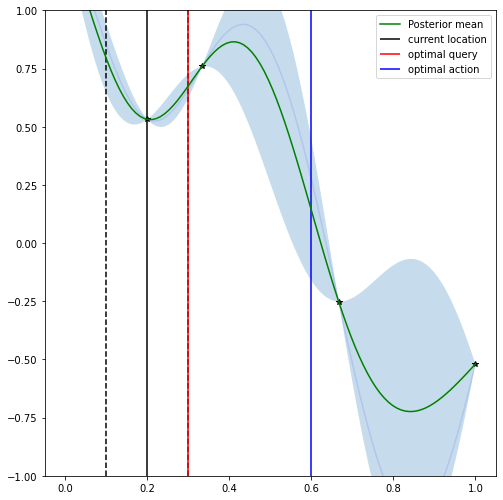

In [ ]:
#@title Joint 3 Steps with sigmoid and adam and sampling

from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch import settings

def compute_ehig(x0, x1, x2, a):
    '''
    x0 to a: unconstraint optimization parameters
    '''
    with settings.propagate_grads(state=True):

        x0 = torch.sigmoid(x0) * 0.2 + (prev_x - 0.1)
        x1 = torch.sigmoid(x1) * 0.2 + (x0 - 0.1)
        x2 = torch.sigmoid(x2) * 0.2 + (x1 - 0.1)
        a = torch.sigmoid(a) * 0.2 + (x2 - 0.1)

        ehigs = 0
        p_y0_on_x0_D0 = model.posterior(x0)
        sampler = SobolQMCNormalSampler(
            num_samples=4, 
            resample=False, collapse_batch_dims=True
        )
        sample_y0_on_x0_D0 = sampler(p_y0_on_x0_D0)

        for ind_x1, y0_on_x0_D0 in enumerate(sample_y0_on_x0_D0):
            p_f_on_D1 = model.condition_on_observations(
                x0, y0_on_x0_D0
            )
            p_y1_on_x1_D1 = p_f_on_D1.posterior(x1[ind_x1, :])
            sample_y1_on_x1_D1 = sampler(p_y1_on_x1_D1)

            for ind_x2, y1_on_x1_D1 in enumerate(sample_y1_on_x1_D1):
                p_f_on_D2 = p_f_on_D1.condition_on_observations(
                    x1[ind_x1, :], y1_on_x1_D1
                )
                p_y2_on_x2_D2 = p_f_on_D2.posterior(x2[ind_x1, ind_x2, :])
                sample_y2_on_x2_D2 = sampler(p_y2_on_x2_D2)

                for ind_a, p_y2_on_x2_D2 in enumerate(sample_y2_on_x2_D2):
                    p_f_on_D3 = p_f_on_D2.condition_on_observations(
                        x2[ind_x1, ind_x2, :], p_y2_on_x2_D2
                    )
                    p_y3_a_D3 = p_f_on_D3.posterior(a[ind_x1, ind_x2, ind_a, :])

                    ehig = p_y3_a_D3.mean
                    ehigs = ehigs + ehig
        
        ehig = ehigs / (4**3)
    return x0, a, ehig.squeeze()

prev_x = 0.2
temp = []

x0 = (torch.rand(1)*10).requires_grad_(True)
x1 = (torch.rand(4, 1)*10).requires_grad_(True)
x2 = (torch.rand(4, 4, 1)*10).requires_grad_(True)
a =  (torch.rand(4, 4, 4, 1)*10).requires_grad_(True)

optimizer = optim.Adam([x0, x1, x2, a], lr=5)
for epoch in tqdm(range(100)):
    optimizer.zero_grad()
    x0_, a_, ehig = compute_ehig(x0, x1, x2, a)
    temp.append([x0_, a_, ehig])
    ehig.backward(retain_graph=True)
    optimizer.step()
    
    if epoch % 10 == 0: 
        print('x0 ', x0.item(), 'a', a[0, 0, 0].item(), 'loss', ehig.item())

# for x0 in tqdm(torch.linspace(-10, 10, 2)):
#     x0 = x0.reshape(1)
#     x0_, a_, ehig = compute_ehig(x0, x1, x2, a)
#     print(ehig)

tmp = []
for i in range(len(temp)):
    tmp.append([temp[i][0], temp[i][1][0, 0, 0], temp[i][2]])
    
tmp = torch.tensor(tmp)
best = torch.argmin(tmp, dim=0)[2].item()
best_x, best_a, best_hes = tmp[best].numpy().tolist()

plt.figure(figsize=(7, 7))
ground_truth(draw=True)

plt.vlines(prev_x, -1, 1, color='black', label='current location')
plt.vlines(prev_x-0.1, -1, 1, color='black', linestyle='--')
plt.vlines(prev_x+0.1, -1, 1, color='black', linestyle='--')

plt.vlines(best_x, -1, 1, color='red', label='optimal query')
plt.vlines(best_a, -1, 1, color='blue', label='optimal action')

plt.plot(
    train_x.cpu().numpy(), 
    train_y.cpu().numpy(), 
    'k*')

# compute posterior
test_x = torch.linspace(0, 1, 100)
posterior = model.posterior(test_x)
test_y = posterior.mean
lower, upper = posterior.mvn.confidence_region()

plt.plot(
    test_x.cpu().detach().numpy(), 
    test_y.cpu().detach().numpy(), 
    'green', label='Posterior mean')

plt.fill_between(
    test_x.cpu().detach().numpy(), 
    lower.cpu().detach().numpy(), 
    upper.cpu().detach().numpy(), 
    alpha=0.25)

plt.tight_layout()
plt.ylim(-1, 1)
plt.legend()

plt.show()

  5%|▌         | 1/20 [00:16<05:20, 16.88s/it]

x0  4.42362117767334 a 4.269712448120117 loss -0.5410947807019745


 15%|█▌        | 3/20 [00:47<04:23, 15.51s/it]

x0  7.003201007843018 a 7.779956817626953 loss -0.695310621794903


 25%|██▌       | 5/20 [01:17<03:48, 15.24s/it]

x0  8.7289457321167 a 10.144371032714844 loss -0.6788471655482043


 35%|███▌      | 7/20 [01:47<03:18, 15.26s/it]

x0  10.008357048034668 a 11.896612167358398 loss -0.7416107516796919


 45%|████▌     | 9/20 [02:17<02:45, 15.04s/it]

x0  11.001667022705078 a 13.256607055664062 loss -0.692721346353932


 55%|█████▌    | 11/20 [02:47<02:15, 15.07s/it]

x0  11.792378425598145 a 14.338812828063965 loss -0.685726285776967


 65%|██████▌   | 13/20 [03:17<01:44, 14.95s/it]

x0  12.431427955627441 a 15.213056564331055 loss -0.7455889814717159


 75%|███████▌  | 15/20 [03:52<01:19, 15.96s/it]

x0  12.952912330627441 a 15.92621898651123 loss -0.7375135519387803


 85%|████████▌ | 17/20 [04:23<00:47, 15.97s/it]

x0  13.3811616897583 a 16.51167869567871 loss -0.6865633850326681


 95%|█████████▌| 19/20 [04:53<00:15, 15.38s/it]

x0  13.734334945678711 a 16.99435043334961 loss -0.6977510390904231


100%|██████████| 20/20 [05:09<00:00, 15.48s/it]


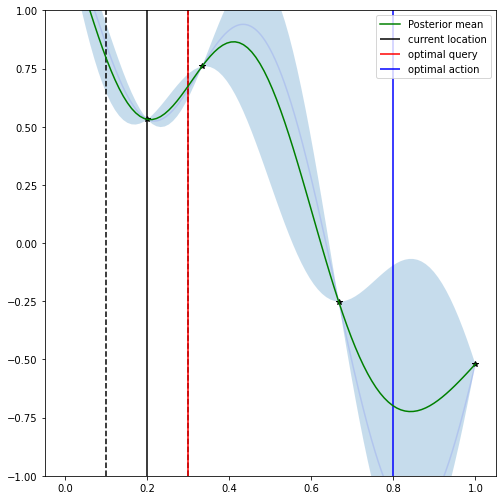

In [ ]:
#@title Joint 5 Steps with sigmoid and adam and sampling

from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch import settings

def compute_ehig(x0, x1, x2, x3, x4, a):
    '''
    x0 to a: unconstraint optimization parameters
    '''
    with settings.propagate_grads(state=True):

        x0 = torch.sigmoid(x0) * 0.2 + (prev_x - 0.1)
        x1 = torch.sigmoid(x1) * 0.2 + (x0 - 0.1)
        x2 = torch.sigmoid(x2) * 0.2 + (x1 - 0.1)
        x3 = torch.sigmoid(x3) * 0.2 + (x2 - 0.1)
        x4 = torch.sigmoid(x4) * 0.2 + (x3 - 0.1)
        a = torch.sigmoid(a) * 0.2 + (x4 - 0.1)

        ehigs = 0
        p_y0_on_x0_D0 = model.posterior(x0)
        sampler = SobolQMCNormalSampler(
            num_samples=4, 
            resample=False, collapse_batch_dims=True
        )
        sample_y0_on_x0_D0 = sampler(p_y0_on_x0_D0)

        for ind_x1, y0_on_x0_D0 in enumerate(sample_y0_on_x0_D0):
            p_f_on_D1 = model.condition_on_observations(
                x0, y0_on_x0_D0
            )
            p_y1_on_x1_D1 = p_f_on_D1.posterior(x1[ind_x1, :])
            sample_y1_on_x1_D1 = sampler(p_y1_on_x1_D1)

            for ind_x2, y1_on_x1_D1 in enumerate(sample_y1_on_x1_D1):
                p_f_on_D2 = p_f_on_D1.condition_on_observations(
                    x1[ind_x1, :], y1_on_x1_D1
                )
                p_y2_on_x2_D2 = p_f_on_D2.posterior(x2[ind_x1, ind_x2, :])
                sample_y2_on_x2_D2 = sampler(p_y2_on_x2_D2)

                for ind_x3, y2_on_x2_D2 in enumerate(sample_y2_on_x2_D2):
                    p_f_on_D3 = p_f_on_D2.condition_on_observations(
                        x2[ind_x1, ind_x2, :], y2_on_x2_D2
                    )
                    p_y3_x3_D3 = p_f_on_D3.posterior(x3[ind_x1, ind_x2, ind_x3, :])
                    sample_y3_x3_D3 = sampler(p_y3_x3_D3)

                    for ind_x4, y3_on_x3_D3 in enumerate(sample_y3_x3_D3):
                        p_f_on_D4 = p_f_on_D3.condition_on_observations(
                            x3[ind_x1, ind_x2, ind_x3, :], y3_on_x3_D3
                        )
                        p_y4_on_x4_D4 = p_f_on_D4.posterior(x4[ind_x1, ind_x2, ind_x3, ind_x4, :])
                        sample_y4_on_x4_D4 = sampler(p_y4_on_x4_D4)

                        for ind_a, y4_on_x4_D4 in enumerate(sample_y4_on_x4_D4):
                            p_f_on_D5 = p_f_on_D4.condition_on_observations(
                                x4[ind_x1, ind_x2, ind_x3, ind_x4, :], y4_on_x4_D4
                            )
                            p_y5_on_a_D5 = p_f_on_D5.posterior(a[ind_x1, ind_x2, ind_x3, ind_x4, ind_a, :])     

                            ehig = p_y5_on_a_D5.mean
                            ehigs = ehigs + ehig
        
        ehig = ehigs / (4**5)
    return x0, a, ehig.squeeze()

prev_x = 0.2
temp = []

x0 = (torch.rand(1)*10).requires_grad_(True)
x1 = (torch.rand(4, 1)*10).requires_grad_(True)
x2 = (torch.rand(4, 4, 1)*10).requires_grad_(True)
x3 = (torch.rand(4, 4, 4, 1)*10).requires_grad_(True)
x4 = (torch.rand(4, 4, 4, 4, 1)*10).requires_grad_(True)
a =  (torch.rand(4, 4, 4, 4, 4, 1)*10).requires_grad_(True)

optimizer = optim.Adam([x0, x1, x2, x3, x4, a], lr=2)
for epoch in tqdm(range(20)):
    optimizer.zero_grad()
    x0_, a_, ehig = compute_ehig(x0, x1, x2, x3, x4, a)
    temp.append([x0_, a_, ehig])
    ehig.backward(retain_graph=True)
    optimizer.step()
    
    if epoch % 2 == 0: 
        print('x0 ', x0.item(), 'a', a[0, 0, 0, 0, 0].item(), 'loss', ehig.item())

# for x0 in tqdm(torch.linspace(-10, 10, 2)):
#     x0 = x0.reshape(1)
#     x0_, a_, ehig = compute_ehig(x0, x1, x2, a)
#     print(ehig)

tmp = []
for i in range(len(temp)):
    tmp.append([temp[i][0], temp[i][1][0, 0, 0, 0, 0], temp[i][2]])
    
tmp = torch.tensor(tmp)
best = torch.argmin(tmp, dim=0)[2].item()
best_x, best_a, best_hes = tmp[best].numpy().tolist()

plt.figure(figsize=(7, 7))
ground_truth(draw=True)

plt.vlines(prev_x, -1, 1, color='black', label='current location')
plt.vlines(prev_x-0.1, -1, 1, color='black', linestyle='--')
plt.vlines(prev_x+0.1, -1, 1, color='black', linestyle='--')

plt.vlines(best_x, -1, 1, color='red', label='optimal query')
plt.vlines(best_a, -1, 1, color='blue', label='optimal action')

plt.plot(
    train_x.cpu().numpy(), 
    train_y.cpu().numpy(), 
    'k*')

# compute posterior
test_x = torch.linspace(0, 1, 100)
posterior = model.posterior(test_x)
test_y = posterior.mean
lower, upper = posterior.mvn.confidence_region()

plt.plot(
    test_x.cpu().detach().numpy(), 
    test_y.cpu().detach().numpy(), 
    'green', label='Posterior mean')

plt.fill_between(
    test_x.cpu().detach().numpy(), 
    lower.cpu().detach().numpy(), 
    upper.cpu().detach().numpy(), 
    alpha=0.25)

plt.tight_layout()
plt.ylim(-1, 1)
plt.legend()

plt.show()

  5%|▌         | 1/20 [00:20<06:21, 20.06s/it]

x0  1.0486482381820679 a 5.2529215812683105 loss -0.17437350311601277


 15%|█▌        | 3/20 [00:52<04:50, 17.06s/it]

x0  2.0117383003234863 a 6.168497562408447 loss -0.5906203991086012


 25%|██▌       | 5/20 [01:25<04:09, 16.60s/it]

x0  2.815899610519409 a 6.813582897186279 loss -0.6409216580410962


 35%|███▌      | 7/20 [01:57<03:32, 16.35s/it]

x0  3.464965581893921 a 7.360840797424316 loss -0.6806118649520252


 45%|████▌     | 9/20 [02:29<02:59, 16.28s/it]

x0  3.9919216632843018 a 7.804483890533447 loss -0.6483973250214178


 55%|█████▌    | 11/20 [03:02<02:26, 16.30s/it]

x0  4.421297073364258 a 8.149369239807129 loss -0.6978029521677973


 65%|██████▌   | 13/20 [03:34<01:53, 16.24s/it]

x0  4.776041030883789 a 8.434184074401855 loss -0.7000256799735124


 75%|███████▌  | 15/20 [04:07<01:21, 16.27s/it]

x0  5.071737289428711 a 8.67286205291748 loss -0.7509360505243766


 85%|████████▌ | 17/20 [04:40<00:48, 16.27s/it]

x0  5.31919002532959 a 8.877298355102539 loss -0.7076227614247814


 95%|█████████▌| 19/20 [05:12<00:16, 16.27s/it]

x0  5.526111602783203 a 9.05202865600586 loss -0.7692696757458544


100%|██████████| 20/20 [05:29<00:00, 16.45s/it]


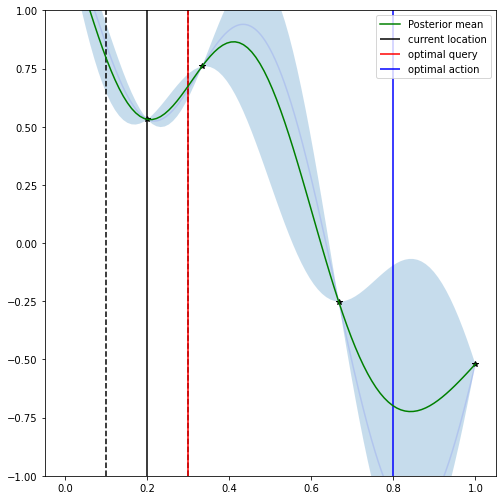

In [ ]:
#@title Joint 5 Steps with sigmoid and adam and sampling -- parallel

from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch import settings
import itertools

def compute_ehig(xi, horizon=5, num_samples=4):
    with settings.propagate_grads(state=True):
        for h in range(0, horizon+1):
            pvs_x = xi[h-1] if h > 0 else prev_x
            xi[h] = torch.sigmoid(xi[h]) * 0.2 + (pvs_x - 0.1)

        ehigs = 0
        sample_yi_on_xi_Di = {}
        prev_ind = np.ones(horizon)*-1
        p_f_on_Di = {} 
        p_f_on_Di[0] = model
        sampler = SobolQMCNormalSampler(
            num_samples=num_samples, 
            resample=False, collapse_batch_dims=True
        )

        p_y0_on_x0_D0 = model.posterior(xi[0])
        sample_yi_on_xi_Di[0] = sampler(p_y0_on_x0_D0)

        for ind in itertools.product(range(num_samples), repeat=horizon):

            equal_bool = np.equal(ind, prev_ind)
            prev_ind = ind

            for i in range(horizon):
                if not equal_bool[i]:
                    p_f_on_Di[i+1] =\
                    p_f_on_Di[i].condition_on_observations(
                        xi[i][ind[:i]], sample_yi_on_xi_Di[i][ind[i]])
                    sample_yi_on_xi_Di[i+1] = sampler(
                        p_f_on_Di[i+1].posterior(xi[i+1][ind[:i+1]])) 

            ehig = sample_yi_on_xi_Di[horizon].mean()
            ehigs = ehigs + ehig

        ehig = ehigs / (num_samples**horizon)

        return xi[0], xi[-1], ehig.squeeze()

prev_x = 0.2
temp = []

xi = []
# xi[-1] = prev_x
dim_xi = [1]
horizon = 5 # 7
for h in range(horizon+1):
    xi.append((torch.rand(dim_xi)*10).requires_grad_(True))
    dim_xi.insert(0, 4)

optimizer = optim.Adam(xi, lr=0.5)
for epoch in tqdm(range(20)):
    optimizer.zero_grad()

    xi_in = [element_xi.clone() for element_xi in xi]
    x0_, a_, ehig = compute_ehig(xi_in, horizon=horizon)
    temp.append([x0_.detach(), a_.detach(), ehig.detach()])

    ehig.backward(retain_graph=True)
    optimizer.step()
    
    if epoch % 2 == 0: 
        print(
            'x0 ', xi[0].item(), 
            'a', xi[horizon][tuple([0]*horizon)].item(), 
            'loss', ehig.item())

tmp = []
for i in range(len(temp)):
    tmp.append([temp[i][0], temp[i][1][tuple([0]*horizon)], temp[i][2]])
    
tmp = torch.tensor(tmp)
best = torch.argmin(tmp, dim=0)[2].item()
best_x, best_a, best_hes = tmp[best].numpy().tolist()

plt.figure(figsize=(7, 7))
ground_truth(draw=True)

plt.vlines(prev_x, -1, 1, color='black', label='current location')
plt.vlines(prev_x-0.1, -1, 1, color='black', linestyle='--')
plt.vlines(prev_x+0.1, -1, 1, color='black', linestyle='--')

plt.vlines(best_x, -1, 1, color='red', label='optimal query')
plt.vlines(best_a, -1, 1, color='blue', label='optimal action')

plt.plot(
    train_x.cpu().numpy(), 
    train_y.cpu().numpy(), 
    'k*')

# compute posterior
test_x = torch.linspace(0, 1, 100)
posterior = model.posterior(test_x)
test_y = posterior.mean
lower, upper = posterior.mvn.confidence_region()

plt.plot(
    test_x.cpu().detach().numpy(), 
    test_y.cpu().detach().numpy(), 
    'green', label='Posterior mean')

plt.fill_between(
    test_x.cpu().detach().numpy(), 
    lower.cpu().detach().numpy(), 
    upper.cpu().detach().numpy(), 
    alpha=0.25)

plt.tight_layout()
plt.ylim(-1, 1)
plt.legend()

plt.show()

  2%|▎         | 1/40 [00:02<01:43,  2.66s/it]

x0  0.2972526252269745 a 1.013552188873291 loss -0.4677758567437102


  8%|▊         | 3/40 [00:07<01:37,  2.62s/it]

x0  0.29281094670295715 a 0.8309714198112488 loss -0.6995036838174381


 12%|█▎        | 5/40 [00:12<01:29,  2.55s/it]

x0  0.291335791349411 a 0.7554004192352295 loss -0.6560586365767093


 18%|█▊        | 7/40 [00:18<01:24,  2.55s/it]

x0  0.295048326253891 a 0.7997264862060547 loss -0.8076017352760613


 22%|██▎       | 9/40 [00:23<01:20,  2.59s/it]

x0  0.2972584068775177 a 0.8620845079421997 loss -0.7751353607570862


 28%|██▊       | 11/40 [00:28<01:14,  2.56s/it]

x0  0.29823577404022217 a 0.8921597003936768 loss -0.4682130102466937


 32%|███▎      | 13/40 [00:33<01:09,  2.57s/it]

x0  0.2987290024757385 a 0.9051167368888855 loss -0.8420699857972035


 38%|███▊      | 15/40 [00:38<01:04,  2.59s/it]

x0  0.2989731729030609 a 0.8772347569465637 loss -0.7336742682123428


 42%|████▎     | 17/40 [00:43<00:58,  2.56s/it]

x0  0.29911959171295166 a 0.8402031660079956 loss -0.6605554665394039


 48%|████▊     | 19/40 [00:48<00:53,  2.57s/it]

x0  0.2992231547832489 a 0.8132305145263672 loss -0.7892730169888624


 52%|█████▎    | 21/40 [00:54<00:49,  2.59s/it]

x0  0.29931068420410156 a 0.8034871220588684 loss -0.5241967249457984


 57%|█████▊    | 23/40 [00:59<00:43,  2.56s/it]

x0  0.29938316345214844 a 0.8021059036254883 loss -0.5655912014308815


 62%|██████▎   | 25/40 [01:05<00:40,  2.72s/it]

x0  0.299445241689682 a 0.8095161318778992 loss -0.7931636753982665


 68%|██████▊   | 27/40 [01:10<00:34,  2.67s/it]

x0  0.2994997799396515 a 0.8282681107521057 loss -0.5842051584784801


 72%|███████▎  | 29/40 [01:15<00:28,  2.59s/it]

x0  0.2995423376560211 a 0.8472381234169006 loss -0.9051855219241086


 78%|███████▊  | 31/40 [01:20<00:23,  2.61s/it]

x0  0.2995741069316864 a 0.8616682887077332 loss -0.6780988450874755


 82%|████████▎ | 33/40 [01:25<00:18,  2.61s/it]

x0  0.29959678649902344 a 0.8686681985855103 loss -0.6033359278086169


 88%|████████▊ | 35/40 [01:30<00:12,  2.58s/it]

x0  0.2996128797531128 a 0.8676807284355164 loss -0.5843286079827731


 92%|█████████▎| 37/40 [01:36<00:07,  2.58s/it]

x0  0.2996242344379425 a 0.861886203289032 loss -0.5536483388479915


 98%|█████████▊| 39/40 [01:41<00:02,  2.56s/it]

x0  0.29963234066963196 a 0.8548970222473145 loss -0.6518741356823232


100%|██████████| 40/40 [01:43<00:00,  2.60s/it]


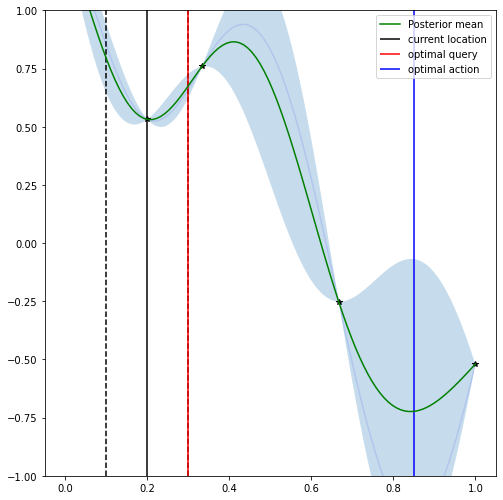

In [ ]:
#@title Joint 10 Steps with sigmoid and adam and sampling and variational

from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch import settings
import itertools

def compute_ehig(xi, horizon=5, num_samples=4):
    with settings.propagate_grads(state=True):
        for h in range(0, horizon+1):
            pvs_x = xi[h-1] if h > 0 else prev_x
            xi[h] = torch.sigmoid(xi[h]) * 0.2 + (pvs_x - 0.1)

        ehigs = 0
        sample_yi_on_xi_Di = {}
        prev_ind = np.ones(horizon)*-1
        p_f_on_Di = {} 
        p_f_on_Di[0] = model
        sampler = SobolQMCNormalSampler(
            num_samples=num_samples, 
            resample=False, collapse_batch_dims=True
        )

        p_y0_on_x0_D0 = model.posterior(xi[0])
        sample_yi_on_xi_Di[0] = sampler(p_y0_on_x0_D0)

        for ind in itertools.product(
            range(4),
            range(3),
            range(2),
        ):
            # range(num_samples), repeat=horizon):

            ind = ind + tuple([0]*(horizon-len(ind)))

            equal_bool = np.equal(ind, prev_ind)

            # finding the first false
            comp_ind = np.argmin(equal_bool)

            prev_ind = ind

            for i in range(horizon):
                if i >= comp_ind:
                    p_f_on_Di[i+1] =\
                    p_f_on_Di[i].condition_on_observations(
                        xi[i],#[ind[:i]], 
                        sample_yi_on_xi_Di[i][ind[i]])
                    sample_yi_on_xi_Di[i+1] = sampler(
                        p_f_on_Di[i+1].posterior(xi[i+1]))#[ind[:i+1]])) 

            ehig = sample_yi_on_xi_Di[horizon].mean()
            ehigs = ehigs + ehig

        ehig = ehigs / (4*3*2)

        return xi, ehig.squeeze()

prev_x = 0.2
temp = []

xi = []
dim_xi = [1]
horizon = 10
num_samples = 4
for h in range(horizon+1):
    xi.append((torch.rand(dim_xi)*10).requires_grad_(True))
    # dim_xi.insert(0, num_samples)

optimizer = optim.Adam(xi, lr=0.5)
for epoch in tqdm(range(40)):
    optimizer.zero_grad()

    xi_in = [element_xi.clone() for element_xi in xi]
    xi_out, ehig = compute_ehig(
        xi_in, horizon=horizon, num_samples=num_samples)
    ehig.backward(retain_graph=True)
    optimizer.step()
    temp.append(
        [xi_out[i].detach() for i in range(horizon+1)] + [ehig.detach()])

    
    if epoch % 2 == 0: 
        print(
            'x0 ', xi_out[0].item(), 
            'a',   xi_out[-1].item(),#[tuple([0]*horizon)].item(), 
            'loss', ehig.item())

tmp = []
for i in range(len(temp)):
    tmp.append([
        temp[i][0], 
        temp[i][-2],#[tuple([0]*horizon)], 
        temp[i][-1]])
    
tmp = torch.tensor(tmp)
best = torch.argmin(tmp, dim=0)[2].item()
best_x, best_a, best_hes = tmp[best].numpy().tolist()

plt.figure(figsize=(7, 7))
ground_truth(draw=True)

plt.vlines(prev_x, -1, 1, color='black', label='current location')
plt.vlines(prev_x-0.1, -1, 1, color='black', linestyle='--')
plt.vlines(prev_x+0.1, -1, 1, color='black', linestyle='--')

plt.vlines(best_x, -1, 1, color='red', label='optimal query')
plt.vlines(best_a, -1, 1, color='blue', label='optimal action')

plt.plot(
    train_x.cpu().numpy(), 
    train_y.cpu().numpy(), 
    'k*')

# compute posterior
test_x = torch.linspace(0, 1, 100)
posterior = model.posterior(test_x)
test_y = posterior.mean
lower, upper = posterior.mvn.confidence_region()

plt.plot(
    test_x.cpu().detach().numpy(), 
    test_y.cpu().detach().numpy(), 
    'green', label='Posterior mean')

plt.fill_between(
    test_x.cpu().detach().numpy(), 
    lower.cpu().detach().numpy(), 
    upper.cpu().detach().numpy(), 
    alpha=0.25)

plt.tight_layout()
plt.ylim(-1, 1)
plt.legend()

plt.show()

#2D case

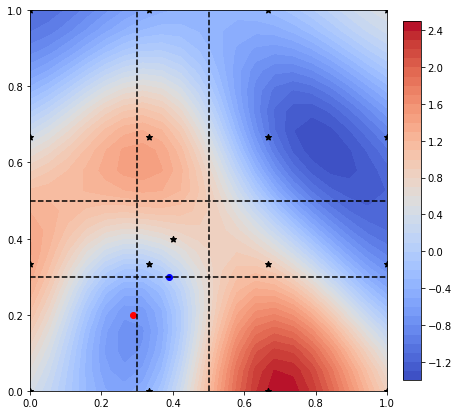

In [ ]:
#@title Naive Myopic
prev_x = torch.tensor([[0.4, 0.4]])
n_dim = 2
model, train_x, train_y = init_model(n_dim=n_dim)

search_space_x = np.mgrid[
    prev_x[0, 0].item() - 0.1 : prev_x[0, 0].item() + 0.1 : 10j, 
    prev_x[0, 1].item() - 0.1 : prev_x[0, 1].item() + 0.1 : 10j
].reshape(2, -1).T

search_space_x = torch.tensor(search_space_x)

temp = []
for x0 in search_space_x:
    x0 = x0.reshape(1, 2)

    p_y0_on_x0_D0 = model.posterior(x0)

    p_f_on_D1 = model.condition_on_observations(
        x0, p_y0_on_x0_D0.mean
    )
    
    search_space_a = np.mgrid[
        x0[0, 0].item() - 0.1 : x0[0, 0].item() + 0.1:10j, 
        x0[0, 1].item() - 0.1 : x0[0, 1].item() + 0.1:10j
    ].reshape(2, -1).T

    search_space_a = torch.tensor(search_space_a)

    for a in search_space_a:
        a = a.reshape(1, 2)

        p_y1_a_D1 = p_f_on_D1.posterior(a)
        temp.append([x0, a, p_y1_a_D1.mean])

tmp = [temp[i][2].squeeze() for i in range(len(temp))]

tmp = torch.tensor(tmp)
best = torch.argmin(tmp, dim=0).item()
best_x, best_a, best_hes = temp[best]

draw_posterior()

plt.scatter(train_x[:, 0], train_x[:, 1], marker='*', color='black')
plt.hlines(prev_x[0, 1] - 0.1, 0, 1, linestyle='--')
plt.hlines(prev_x[0, 1] + 0.1, 0, 1, linestyle='--')

plt.vlines(prev_x[0, 0] - 0.1, 0, 1, linestyle='--')
plt.vlines(prev_x[0, 0] + 0.1, 0, 1, linestyle='--')

plt.scatter(best_x[0, 0], best_x[0, 1], color='blue')
plt.scatter(best_a[0, 0], best_a[0, 1], color='red')

plt.show()

100%|██████████| 4/4 [03:13<00:00, 48.42s/it]


<Figure size 504x504 with 0 Axes>

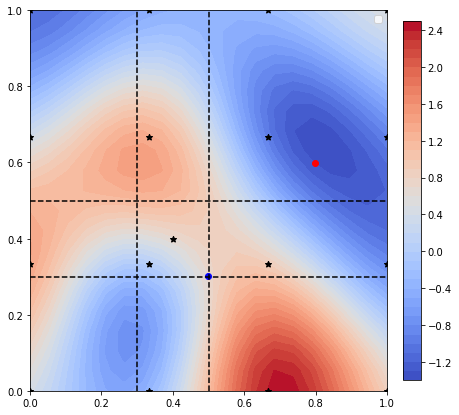

In [ ]:
#@title Joint 5 Steps with sigmoid

def compute_ehig(x0, x1, x2, x3, x4, a):
    '''
    x0 to a: unconstraint optimization parameters
    '''
    x0 = torch.sigmoid(x0) * 0.2 + (prev_x - 0.1)

    x1 = torch.sigmoid(x1) * 0.2 + (x0 - 0.1)

    x2 = torch.sigmoid(x2) * 0.2 + (x1 - 0.1)

    x3 = torch.sigmoid(x3) * 0.2 + (x2 - 0.1)
    
    x4 = torch.sigmoid(x4) * 0.2 + (x3 - 0.1)

    a = torch.sigmoid(a) * 0.2 + (x4 - 0.1)

    x0 = x0.reshape(1, 2)
    x1 = x1.reshape(1, 2)
    x2 = x2.reshape(1, 2)
    x3 = x3.reshape(1, 2)
    x4 = x4.reshape(1, 2)
    a = a.reshape(1, 2)

    p_y0_on_x0_D0 = model.posterior(x0)
    p_f_on_D1 = model.condition_on_observations(
        x0, p_y0_on_x0_D0.mean
    )

    p_y1_on_x1_D1 = p_f_on_D1.posterior(x1)
    p_f_on_D2 = p_f_on_D1.condition_on_observations(
        x1, p_y1_on_x1_D1.mean
    )

    p_y2_on_x2_D2 = p_f_on_D2.posterior(x2)
    p_f_on_D3 = p_f_on_D2.condition_on_observations(
        x2, p_y2_on_x2_D2.mean
    )

    p_y3_on_x3_D3 = p_f_on_D3.posterior(x3)
    p_f_on_D4 = p_f_on_D3.condition_on_observations(
        x3, p_y3_on_x3_D3.mean
    )

    p_y4_on_x4_D4 = p_f_on_D3.posterior(x4)
    p_f_on_D5 = p_f_on_D4.condition_on_observations(
        x4, p_y4_on_x4_D4.mean
    )

    p_y5_a_D5 = p_f_on_D5.posterior(a)

    ehig = p_y5_a_D5.mean

    return x0, x1, x2, x3, x4, a, ehig

temp = []

search_space = np.mgrid[
    -6 : 6 : 2j, 
    -6 : 6 : 2j,
].reshape(2, -1).T

search_space = torch.tensor(search_space)

for x0 in tqdm(search_space):
    for x1 in search_space:
        for x2 in search_space:
            for x3 in search_space:
                for x4 in search_space:
                    for a in search_space:
                        x0_, x1_, x2_, x3_, x4_, a_, ehig = compute_ehig(x0, x1, x2, x3, x4, a)

                temp.append([x0_, x1_, x2_, x3_, x4_, a_, ehig])

tmp = []
for i in range(len(temp)):
    tmp.append([
        temp[i][0], 
        temp[i][-2],#[tuple([0]*horizon)], 
        temp[i][-1]])
    
tmp2 = []
for i in range(len(temp)):
    tmp2.append([
        # temp[i][0], 
        # temp[i][-2],#[tuple([0]*horizon)], 
        temp[i][-1]])

tmp2 = torch.tensor(tmp2)
best = torch.argmin(tmp2, dim=0).item()

best_x, best_a, best_hes = tmp[best]

plt.figure(figsize=(7, 7))

draw_posterior()

plt.scatter(train_x[:, 0], train_x[:, 1], marker='*', color='black')
plt.hlines(prev_x[0, 1]-0.1, 0, 1, linestyle='--')
plt.hlines(prev_x[0, 1]+0.1, 0, 1, linestyle='--')

plt.vlines(prev_x[0, 0]-0.1, 0, 1, linestyle='--')
plt.vlines(prev_x[0, 0]+0.1, 0, 1, linestyle='--')

plt.scatter(best_x[0, 0], best_x[0, 1], color='blue')
plt.scatter(best_a[..., 0, 0], best_a[..., 0, 1], color='red')

plt.legend()
plt.show()

  0%|          | 2/500 [00:00<00:35, 14.15it/s]

-0.17174978585873785 tensor([0.3571, 3.9350], requires_grad=True) tensor([2.7116, 2.3655], requires_grad=True) tensor([3.2167, 3.3830], requires_grad=True) tensor([2.6834, 0.1479], requires_grad=True)


 21%|██        | 104/500 [00:06<00:29, 13.58it/s]

-1.3899084583861996 tensor([-1.9557,  4.3877], requires_grad=True) tensor([4.3649, 2.2870], requires_grad=True) tensor([5.0192, 3.7287], requires_grad=True) tensor([ 4.3258, -3.4753], requires_grad=True)


 41%|████      | 204/500 [00:13<00:18, 15.87it/s]

-1.38990849551188 tensor([-1.9557,  4.3871], requires_grad=True) tensor([4.3655, 2.2861], requires_grad=True) tensor([5.0197, 3.7280], requires_grad=True) tensor([ 4.3264, -3.4761], requires_grad=True)


 61%|██████    | 304/500 [00:19<00:12, 16.05it/s]

-1.3899084956990815 tensor([-1.9557,  4.3871], requires_grad=True) tensor([4.3655, 2.2862], requires_grad=True) tensor([5.0197, 3.7280], requires_grad=True) tensor([ 4.3264, -3.4761], requires_grad=True)


 81%|████████  | 404/500 [00:25<00:05, 16.02it/s]

-1.3899084956990815 tensor([-1.9557,  4.3871], requires_grad=True) tensor([4.3655, 2.2862], requires_grad=True) tensor([5.0197, 3.7280], requires_grad=True) tensor([ 4.3264, -3.4761], requires_grad=True)


100%|██████████| 500/500 [00:31<00:00, 15.63it/s]


<Figure size 504x504 with 0 Axes>

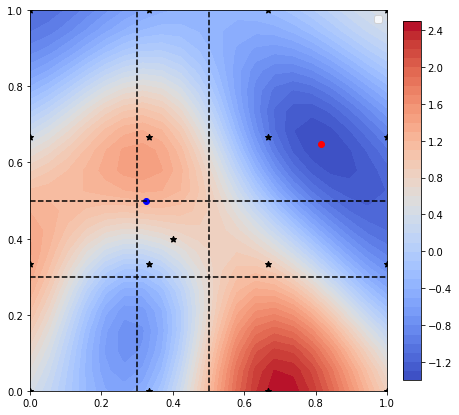

In [ ]:
# @title Joint 5 Steps with sigmoid and adam

def compute_ehig(x0, x1, x2, x3, x4, a):
    '''
    x0 to a: unconstraint optimization parameters
    '''
    x0 = torch.sigmoid(x0) * 0.2 + (prev_x - 0.1)

    x1 = torch.sigmoid(x1) * 0.2 + (x0 - 0.1)

    x2 = torch.sigmoid(x2) * 0.2 + (x1 - 0.1)

    x3 = torch.sigmoid(x3) * 0.2 + (x2 - 0.1)
    
    x4 = torch.sigmoid(x4) * 0.2 + (x3 - 0.1)

    a = torch.sigmoid(a) * 0.2 + (x4 - 0.1)

    x0 = x0.reshape(1, 2)
    x1 = x1.reshape(1, 2)
    x2 = x2.reshape(1, 2)
    x3 = x3.reshape(1, 2)
    x4 = x4.reshape(1, 2)
    a = a.reshape(1, 2)

    p_y0_on_x0_D0 = model.posterior(x0)
    p_f_on_D1 = model.condition_on_observations(
        x0, p_y0_on_x0_D0.mean
    )

    p_y1_on_x1_D1 = p_f_on_D1.posterior(x1)
    p_f_on_D2 = p_f_on_D1.condition_on_observations(
        x1, p_y1_on_x1_D1.mean
    )

    p_y2_on_x2_D2 = p_f_on_D2.posterior(x2)
    p_f_on_D3 = p_f_on_D2.condition_on_observations(
        x2, p_y2_on_x2_D2.mean
    )

    p_y3_on_x3_D3 = p_f_on_D3.posterior(x3)
    p_f_on_D4 = p_f_on_D3.condition_on_observations(
        x3, p_y3_on_x3_D3.mean
    )

    p_y4_on_x4_D4 = p_f_on_D3.posterior(x4)
    p_f_on_D5 = p_f_on_D4.condition_on_observations(
        x4, p_y4_on_x4_D4.mean
    )

    p_y5_a_D5 = p_f_on_D5.posterior(a)

    ehig = p_y5_a_D5.mean

    return x0, x1, x2, x3, x4, a, ehig

temp = []

import torch.optim as optim
import copy 

x0 = (torch.rand(n_dim)*6).requires_grad_(True)
x1 = (torch.rand(n_dim)*6).requires_grad_(True)
x2 = (torch.rand(n_dim)*6).requires_grad_(True)
x3 = (torch.rand(n_dim)*6).requires_grad_(True)
x4 = (torch.rand(n_dim)*6).requires_grad_(True)
a = (torch.rand(n_dim)*6).requires_grad_(True)

optimizer = optim.Adam([x0, x1, x2, x3, x4, a], lr=0.5)

for epoch in tqdm(range(500)):
    optimizer.zero_grad()
    x0_, x1_, x2_, x3_, x4_, a_, ehig = compute_ehig(x0, x1, x2, x3, x4, a)
    temp.append([x0_, a_, ehig])
    ehig.backward(retain_graph=True)
    optimizer.step()

    if epoch % 100 == 0: 
        print(ehig.item(), x0, x1, x2, a)


tmp = []
for i in range(len(temp)):
    tmp.append([
        temp[i][0], 
        temp[i][-2],#[tuple([0]*horizon)], 
        temp[i][-1]])
    
tmp2 = []
for i in range(len(temp)):
    tmp2.append([
        # temp[i][0], 
        # temp[i][-2],#[tuple([0]*horizon)], 
        temp[i][-1]])

tmp2 = torch.tensor(tmp2)
best = torch.argmin(tmp2, dim=0).item()

best_x, best_a, best_hes = tmp[best]

plt.figure(figsize=(7, 7))

draw_posterior()

plt.scatter(train_x[:, 0], train_x[:, 1], marker='*', color='black')
plt.hlines(prev_x[0, 1]-0.1, 0, 1, linestyle='--')
plt.hlines(prev_x[0, 1]+0.1, 0, 1, linestyle='--')

plt.vlines(prev_x[0, 0]-0.1, 0, 1, linestyle='--')
plt.vlines(prev_x[0, 0]+0.1, 0, 1, linestyle='--')

plt.scatter(best_x[0, 0].detach().numpy(), best_x[0, 1].detach().numpy(), color='blue')
plt.scatter(best_a[..., 0, 0].detach().numpy(), best_a[..., 0, 1].detach().numpy(), color='red')

plt.legend()
plt.show()

  5%|▌         | 1/20 [00:17<05:36, 17.69s/it]

x0  tensor([[1.3849, 5.2884]], requires_grad=True) a tensor([[4.2968, 7.0163]], grad_fn=<SelectBackward0>) loss tensor(-0.1112, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 15%|█▌        | 3/20 [00:51<04:52, 17.23s/it]

x0  tensor([[0.3906, 4.3188]], requires_grad=True) a tensor([[3.3107, 6.0578]], grad_fn=<SelectBackward0>) loss tensor(-0.4660, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 25%|██▌       | 5/20 [01:25<04:15, 17.01s/it]

x0  tensor([[-0.1179,  3.3362]], requires_grad=True) a tensor([[3.0196, 5.1549]], grad_fn=<SelectBackward0>) loss tensor(-0.6387, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 35%|███▌      | 7/20 [02:03<03:54, 18.02s/it]

x0  tensor([[0.2129, 2.4693]], requires_grad=True) a tensor([[3.6210, 4.3562]], grad_fn=<SelectBackward0>) loss tensor(-0.8150, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 45%|████▌     | 9/20 [02:38<03:14, 17.70s/it]

x0  tensor([[0.8388, 2.1411]], requires_grad=True) a tensor([[4.2040, 4.6278]], grad_fn=<SelectBackward0>) loss tensor(-1.0914, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 55%|█████▌    | 11/20 [03:12<02:36, 17.42s/it]

x0  tensor([[1.4505, 1.9344]], requires_grad=True) a tensor([[4.6807, 5.1121]], grad_fn=<SelectBackward0>) loss tensor(-1.1826, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 65%|██████▌   | 13/20 [03:45<01:59, 17.10s/it]

x0  tensor([[1.8578, 1.9980]], requires_grad=True) a tensor([[5.0373, 5.2487]], grad_fn=<SelectBackward0>) loss tensor(-1.1930, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 75%|███████▌  | 15/20 [04:20<01:25, 17.11s/it]

x0  tensor([[2.0224, 2.5263]], requires_grad=True) a tensor([[5.2994, 5.3446]], grad_fn=<SelectBackward0>) loss tensor(-1.1823, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 85%|████████▌ | 17/20 [04:54<00:51, 17.12s/it]

x0  tensor([[2.0642, 2.7709]], requires_grad=True) a tensor([[5.4900, 5.2416]], grad_fn=<SelectBackward0>) loss tensor(-1.2242, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 95%|█████████▌| 19/20 [05:28<00:17, 17.09s/it]

x0  tensor([[2.0344, 2.8988]], requires_grad=True) a tensor([[5.6290, 5.0256]], grad_fn=<SelectBackward0>) loss tensor(-1.2291, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


100%|██████████| 20/20 [05:46<00:00, 17.30s/it]


<Figure size 504x504 with 0 Axes>

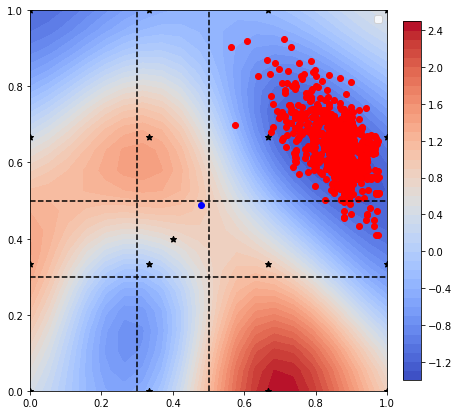

In [ ]:
#@title Joint 5 Steps with sigmoid and adam and sampling -- parallel

from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch import settings
import itertools

def compute_ehig(xi, horizon=5, num_samples=4):
    with settings.propagate_grads(state=True):
        for h in range(0, horizon+1):
            pvs_x = xi[h-1] if h > 0 else prev_x
            xi[h] = torch.sigmoid(xi[h]) * 0.2 + (pvs_x - 0.1)

        ehigs = 0
        sample_yi_on_xi_Di = {}
        prev_ind = np.ones(horizon)*-1
        p_f_on_Di = {} 
        p_f_on_Di[0] = model
        sampler = SobolQMCNormalSampler(
            num_samples=num_samples, 
            resample=False, collapse_batch_dims=True
        )

        p_y0_on_x0_D0 = model.posterior(xi[0])
        sample_yi_on_xi_Di[0] = sampler(p_y0_on_x0_D0)

        for ind in itertools.product(range(num_samples), repeat=horizon):

            equal_bool = np.equal(ind, prev_ind)
            prev_ind = ind

            for i in range(horizon):
                if not equal_bool[i]:
                    p_f_on_Di[i+1] =\
                    p_f_on_Di[i].condition_on_observations(
                        xi[i][ind[:i]], sample_yi_on_xi_Di[i][ind[i]])
                    sample_yi_on_xi_Di[i+1] = sampler(
                        p_f_on_Di[i+1].posterior(xi[i+1][ind[:i+1]])) 

            ehig = sample_yi_on_xi_Di[horizon].mean()
            ehigs = ehigs + ehig

        ehig = ehigs / (num_samples**horizon)

        return xi[0], xi[-1], ehig.squeeze()

temp = []

xi = []
# xi[-1] = prev_x

dim_xi = [1, n_dim]
horizon = 5 # 7
for h in range(horizon+1):
    xi.append((torch.rand(dim_xi)*10).requires_grad_(True))
    dim_xi.insert(0, 4)

optimizer = optim.Adam(xi, lr=0.5)
for epoch in tqdm(range(20)):
    optimizer.zero_grad()

    xi_in = [element_xi.clone() for element_xi in xi]
    x0_, a_, ehig = compute_ehig(xi_in, horizon=horizon)
    temp.append([x0_.detach(), a_.detach(), ehig.detach()])

    ehig.backward(retain_graph=True)
    optimizer.step()
    
    if epoch % 2 == 0: 
        print(
            'x0 ', xi[0], 
            'a', xi[horizon][tuple([0]*horizon)], 
            'loss', ehig)



tmp = []
for i in range(len(temp)):
    tmp.append([
        temp[i][0], 
        temp[i][-2],#[tuple([0]*horizon)], 
        temp[i][-1]])
    
tmp2 = []
for i in range(len(temp)):
    tmp2.append([
        # temp[i][0], 
        # temp[i][-2],#[tuple([0]*horizon)], 
        temp[i][-1]])

tmp2 = torch.tensor(tmp2)
best = torch.argmin(tmp2, dim=0).item()

best_x, best_a, best_hes = tmp[best]

plt.figure(figsize=(7, 7))

draw_posterior()

plt.scatter(train_x[:, 0], train_x[:, 1], marker='*', color='black')
plt.hlines(prev_x[0, 1]-0.1, 0, 1, linestyle='--')
plt.hlines(prev_x[0, 1]+0.1, 0, 1, linestyle='--')

plt.vlines(prev_x[0, 0]-0.1, 0, 1, linestyle='--')
plt.vlines(prev_x[0, 0]+0.1, 0, 1, linestyle='--')

plt.scatter(best_x[0, 0].detach().numpy(), best_x[0, 1].detach().numpy(), color='blue')
plt.scatter(best_a[..., 0, 0].detach().numpy(), best_a[..., 0, 1].detach().numpy(), color='red')

plt.legend()
plt.show()

  1%|          | 1/100 [00:03<05:49,  3.53s/it]

x0  tensor([[0.4997, 0.4197]], grad_fn=<AddBackward0>) a tensor([[1.1341, 0.9900]], grad_fn=<AddBackward0>) loss tensor(0.5004, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


  3%|▎         | 3/100 [00:07<03:38,  2.25s/it]

x0  tensor([[0.4998, 0.4100]], grad_fn=<AddBackward0>) a tensor([[1.1428, 0.9646]], grad_fn=<AddBackward0>) loss tensor(0.4417, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


  5%|▌         | 5/100 [00:10<03:07,  1.98s/it]

x0  tensor([[0.4998, 0.4000]], grad_fn=<AddBackward0>) a tensor([[1.1507, 0.9383]], grad_fn=<AddBackward0>) loss tensor(0.3802, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


  7%|▋         | 7/100 [00:14<02:53,  1.87s/it]

x0  tensor([[0.4999, 0.3899]], grad_fn=<AddBackward0>) a tensor([[1.1574, 0.9113]], grad_fn=<AddBackward0>) loss tensor(0.3189, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


  9%|▉         | 9/100 [00:18<02:43,  1.80s/it]

x0  tensor([[0.4999, 0.3800]], grad_fn=<AddBackward0>) a tensor([[1.1627, 0.8840]], grad_fn=<AddBackward0>) loss tensor(0.2571, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 11%|█         | 11/100 [00:21<02:41,  1.81s/it]

x0  tensor([[0.4999, 0.3705]], grad_fn=<AddBackward0>) a tensor([[1.1666, 0.8567]], grad_fn=<AddBackward0>) loss tensor(0.1944, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 13%|█▎        | 13/100 [00:25<02:34,  1.77s/it]

x0  tensor([[0.4999, 0.3615]], grad_fn=<AddBackward0>) a tensor([[1.1692, 0.8296]], grad_fn=<AddBackward0>) loss tensor(0.1311, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 15%|█▌        | 15/100 [00:28<02:29,  1.76s/it]

x0  tensor([[0.4999, 0.3532]], grad_fn=<AddBackward0>) a tensor([[1.1706, 0.8031]], grad_fn=<AddBackward0>) loss tensor(0.0681, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 17%|█▋        | 17/100 [00:32<02:28,  1.79s/it]

x0  tensor([[0.4999, 0.3458]], grad_fn=<AddBackward0>) a tensor([[1.1708, 0.7774]], grad_fn=<AddBackward0>) loss tensor(0.0058, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 19%|█▉        | 19/100 [00:35<02:23,  1.77s/it]

x0  tensor([[0.4999, 0.3392]], grad_fn=<AddBackward0>) a tensor([[1.1698, 0.7526]], grad_fn=<AddBackward0>) loss tensor(-0.0561, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 21%|██        | 21/100 [00:39<02:18,  1.76s/it]

x0  tensor([[0.4999, 0.3336]], grad_fn=<AddBackward0>) a tensor([[1.1676, 0.7288]], grad_fn=<AddBackward0>) loss tensor(-0.1193, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 23%|██▎       | 23/100 [00:42<02:18,  1.80s/it]

x0  tensor([[0.4999, 0.3287]], grad_fn=<AddBackward0>) a tensor([[1.1640, 0.7060]], grad_fn=<AddBackward0>) loss tensor(-0.1849, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 25%|██▌       | 25/100 [00:46<02:14,  1.79s/it]

x0  tensor([[0.4999, 0.3246]], grad_fn=<AddBackward0>) a tensor([[1.1590, 0.6841]], grad_fn=<AddBackward0>) loss tensor(-0.2531, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 27%|██▋       | 27/100 [00:49<02:08,  1.76s/it]

x0  tensor([[0.4999, 0.3212]], grad_fn=<AddBackward0>) a tensor([[1.1524, 0.6629]], grad_fn=<AddBackward0>) loss tensor(-0.3253, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 29%|██▉       | 29/100 [00:53<02:07,  1.79s/it]

x0  tensor([[0.4999, 0.3184]], grad_fn=<AddBackward0>) a tensor([[1.1440, 0.6419]], grad_fn=<AddBackward0>) loss tensor(-0.4039, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 31%|███       | 31/100 [00:56<01:59,  1.74s/it]

x0  tensor([[0.4999, 0.3160]], grad_fn=<AddBackward0>) a tensor([[1.1339, 0.6207]], grad_fn=<AddBackward0>) loss tensor(-0.4913, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 33%|███▎      | 33/100 [01:00<01:54,  1.72s/it]

x0  tensor([[0.4999, 0.3141]], grad_fn=<AddBackward0>) a tensor([[1.1221, 0.5984]], grad_fn=<AddBackward0>) loss tensor(-0.5915, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 35%|███▌      | 35/100 [01:04<01:55,  1.77s/it]

x0  tensor([[0.4998, 0.3124]], grad_fn=<AddBackward0>) a tensor([[1.1092, 0.5745]], grad_fn=<AddBackward0>) loss tensor(-0.7286, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 37%|███▋      | 37/100 [01:07<01:51,  1.76s/it]

x0  tensor([[0.4998, 0.3110]], grad_fn=<AddBackward0>) a tensor([[1.0955, 0.5485]], grad_fn=<AddBackward0>) loss tensor(-0.8258, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 39%|███▉      | 39/100 [01:10<01:45,  1.73s/it]

x0  tensor([[0.4997, 0.3099]], grad_fn=<AddBackward0>) a tensor([[1.0811, 0.5198]], grad_fn=<AddBackward0>) loss tensor(-0.9113, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 41%|████      | 41/100 [01:14<01:44,  1.77s/it]

x0  tensor([[0.4997, 0.3090]], grad_fn=<AddBackward0>) a tensor([[1.0666, 0.4887]], grad_fn=<AddBackward0>) loss tensor(-0.9796, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 43%|████▎     | 43/100 [01:17<01:39,  1.74s/it]

x0  tensor([[0.4995, 0.3083]], grad_fn=<AddBackward0>) a tensor([[1.0522, 0.4572]], grad_fn=<AddBackward0>) loss tensor(-1.0194, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 45%|████▌     | 45/100 [01:21<01:36,  1.75s/it]

x0  tensor([[0.4994, 0.3077]], grad_fn=<AddBackward0>) a tensor([[1.0382, 0.4309]], grad_fn=<AddBackward0>) loss tensor(-1.0314, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 47%|████▋     | 47/100 [01:25<01:33,  1.76s/it]

x0  tensor([[0.4992, 0.3074]], grad_fn=<AddBackward0>) a tensor([[1.0245, 0.4167]], grad_fn=<AddBackward0>) loss tensor(-1.0345, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 49%|████▉     | 49/100 [01:28<01:28,  1.74s/it]

x0  tensor([[0.4989, 0.3071]], grad_fn=<AddBackward0>) a tensor([[1.0108, 0.4166]], grad_fn=<AddBackward0>) loss tensor(-1.0486, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 51%|█████     | 51/100 [01:31<01:24,  1.72s/it]

x0  tensor([[0.4985, 0.3070]], grad_fn=<AddBackward0>) a tensor([[0.9964, 0.4275]], grad_fn=<AddBackward0>) loss tensor(-1.0773, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 53%|█████▎    | 53/100 [01:35<01:22,  1.75s/it]

x0  tensor([[0.4980, 0.3069]], grad_fn=<AddBackward0>) a tensor([[0.9805, 0.4448]], grad_fn=<AddBackward0>) loss tensor(-1.1157, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 55%|█████▌    | 55/100 [01:38<01:18,  1.74s/it]

x0  tensor([[0.4972, 0.3068]], grad_fn=<AddBackward0>) a tensor([[0.9623, 0.4653]], grad_fn=<AddBackward0>) loss tensor(-1.1581, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 57%|█████▋    | 57/100 [01:42<01:14,  1.73s/it]

x0  tensor([[0.4961, 0.3068]], grad_fn=<AddBackward0>) a tensor([[0.9413, 0.4866]], grad_fn=<AddBackward0>) loss tensor(-1.2002, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 59%|█████▉    | 59/100 [01:45<01:12,  1.78s/it]

x0  tensor([[0.4946, 0.3068]], grad_fn=<AddBackward0>) a tensor([[0.9187, 0.5072]], grad_fn=<AddBackward0>) loss tensor(-1.2395, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 61%|██████    | 61/100 [01:49<01:09,  1.78s/it]

x0  tensor([[0.4924, 0.3068]], grad_fn=<AddBackward0>) a tensor([[0.8989, 0.5263]], grad_fn=<AddBackward0>) loss tensor(-1.2763, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 63%|██████▎   | 63/100 [01:52<01:04,  1.75s/it]

x0  tensor([[0.4894, 0.3069]], grad_fn=<AddBackward0>) a tensor([[0.8856, 0.5434]], grad_fn=<AddBackward0>) loss tensor(-1.3132, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 65%|██████▌   | 65/100 [01:56<01:01,  1.77s/it]

x0  tensor([[0.4851, 0.3070]], grad_fn=<AddBackward0>) a tensor([[0.8763, 0.5582]], grad_fn=<AddBackward0>) loss tensor(-1.3492, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 67%|██████▋   | 67/100 [01:59<00:57,  1.75s/it]

x0  tensor([[0.4793, 0.3071]], grad_fn=<AddBackward0>) a tensor([[0.8667, 0.5705]], grad_fn=<AddBackward0>) loss tensor(-1.3822, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 69%|██████▉   | 69/100 [02:03<00:53,  1.71s/it]

x0  tensor([[0.4714, 0.3072]], grad_fn=<AddBackward0>) a tensor([[0.8543, 0.5807]], grad_fn=<AddBackward0>) loss tensor(-1.4111, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 71%|███████   | 71/100 [02:06<00:50,  1.73s/it]

x0  tensor([[0.4614, 0.3074]], grad_fn=<AddBackward0>) a tensor([[0.8409, 0.5891]], grad_fn=<AddBackward0>) loss tensor(-1.4333, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 73%|███████▎  | 73/100 [02:10<00:46,  1.72s/it]

x0  tensor([[0.4525, 0.3076]], grad_fn=<AddBackward0>) a tensor([[0.8364, 0.5963]], grad_fn=<AddBackward0>) loss tensor(-1.4508, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 75%|███████▌  | 75/100 [02:13<00:43,  1.73s/it]

x0  tensor([[0.4470, 0.3078]], grad_fn=<AddBackward0>) a tensor([[0.8415, 0.6023]], grad_fn=<AddBackward0>) loss tensor(-1.4651, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 77%|███████▋  | 77/100 [02:17<00:40,  1.74s/it]

x0  tensor([[0.4402, 0.3081]], grad_fn=<AddBackward0>) a tensor([[0.8428, 0.6074]], grad_fn=<AddBackward0>) loss tensor(-1.4741, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 79%|███████▉  | 79/100 [02:20<00:36,  1.71s/it]

x0  tensor([[0.4306, 0.3084]], grad_fn=<AddBackward0>) a tensor([[0.8366, 0.6118]], grad_fn=<AddBackward0>) loss tensor(-1.4812, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 81%|████████  | 81/100 [02:24<00:32,  1.69s/it]

x0  tensor([[0.4222, 0.3087]], grad_fn=<AddBackward0>) a tensor([[0.8318, 0.6157]], grad_fn=<AddBackward0>) loss tensor(-1.4856, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 83%|████████▎ | 83/100 [02:27<00:28,  1.68s/it]

x0  tensor([[0.4188, 0.3090]], grad_fn=<AddBackward0>) a tensor([[0.8351, 0.6192]], grad_fn=<AddBackward0>) loss tensor(-1.4898, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 85%|████████▌ | 85/100 [02:30<00:26,  1.74s/it]

x0  tensor([[0.4157, 0.3093]], grad_fn=<AddBackward0>) a tensor([[0.8377, 0.6225]], grad_fn=<AddBackward0>) loss tensor(-1.4924, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 87%|████████▋ | 87/100 [02:34<00:22,  1.74s/it]

x0  tensor([[0.4097, 0.3097]], grad_fn=<AddBackward0>) a tensor([[0.8341, 0.6254]], grad_fn=<AddBackward0>) loss tensor(-1.4950, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 89%|████████▉ | 89/100 [02:38<00:19,  1.78s/it]

x0  tensor([[0.4043, 0.3101]], grad_fn=<AddBackward0>) a tensor([[0.8305, 0.6282]], grad_fn=<AddBackward0>) loss tensor(-1.4968, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 91%|█████████ | 91/100 [02:41<00:15,  1.74s/it]

x0  tensor([[0.4024, 0.3105]], grad_fn=<AddBackward0>) a tensor([[0.8319, 0.6308]], grad_fn=<AddBackward0>) loss tensor(-1.4987, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 93%|█████████▎| 93/100 [02:44<00:12,  1.71s/it]

x0  tensor([[0.4013, 0.3109]], grad_fn=<AddBackward0>) a tensor([[0.8335, 0.6332]], grad_fn=<AddBackward0>) loss tensor(-1.5001, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 95%|█████████▌| 95/100 [02:48<00:08,  1.74s/it]

x0  tensor([[0.3983, 0.3113]], grad_fn=<AddBackward0>) a tensor([[0.8310, 0.6354]], grad_fn=<AddBackward0>) loss tensor(-1.5018, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 97%|█████████▋| 97/100 [02:51<00:05,  1.73s/it]

x0  tensor([[0.3955, 0.3118]], grad_fn=<AddBackward0>) a tensor([[0.8279, 0.6375]], grad_fn=<AddBackward0>) loss tensor(-1.5033, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


 99%|█████████▉| 99/100 [02:55<00:01,  1.72s/it]

x0  tensor([[0.3952, 0.3122]], grad_fn=<AddBackward0>) a tensor([[0.8279, 0.6395]], grad_fn=<AddBackward0>) loss tensor(-1.5050, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


100%|██████████| 100/100 [02:57<00:00,  1.77s/it]


<Figure size 504x504 with 0 Axes>

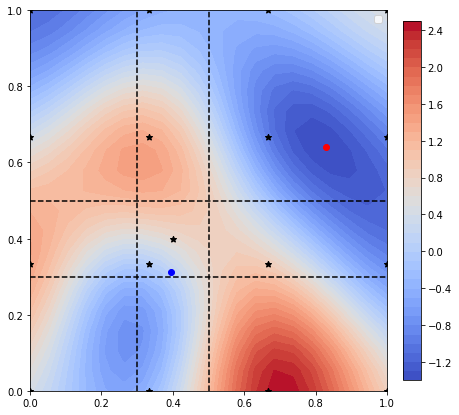

In [ ]:
#@title Joint 10 Steps with sigmoid and adam and sampling and variational

def compute_ehig(xi, horizon=5, num_samples=4):
    with settings.propagate_grads(state=True):
        for h in range(0, horizon+1):
            pvs_x = xi[h-1] if h > 0 else prev_x
            xi[h] = torch.sigmoid(xi[h]) * 0.2 + (pvs_x - 0.1)
            
            # if torch.any(xi[h] > 1):
            #     xi[h] = torch.clamp(xi[h], min=0, max=1)

        ehigs = 0
        sample_yi_on_xi_Di = {}
        prev_ind = np.ones(horizon)*-1
        p_f_on_Di = {} 
        p_f_on_Di[0] = model
        sampler = SobolQMCNormalSampler(
            num_samples=num_samples, 
            resample=False, collapse_batch_dims=True,
            seed=0
        )

        p_y0_on_x0_D0 = model.posterior(xi[0])
        sample_yi_on_xi_Di[0] = sampler(p_y0_on_x0_D0)

        for ind in itertools.product(
            range(4),
            range(3),
            range(2),
        ):
            # range(num_samples), repeat=horizon):

            ind = ind + tuple([0]*(horizon-len(ind)))

            equal_bool = np.equal(ind, prev_ind)

            # finding the first false
            comp_ind = np.argmin(equal_bool)

            prev_ind = ind

            for i in range(horizon):
                if i >= comp_ind:
                    p_f_on_Di[i+1] =\
                    p_f_on_Di[i].condition_on_observations(
                        xi[i],#[ind[:i]], 
                        sample_yi_on_xi_Di[i][ind[i]])
                    sample_yi_on_xi_Di[i+1] = sampler(
                        p_f_on_Di[i+1].posterior(xi[i+1]))#[ind[:i+1]])) 

            ehig = sample_yi_on_xi_Di[horizon].mean()
            ehigs = ehigs + ehig

        ehig = ehigs / (4*3*2)

        return xi, ehig.squeeze()

temp = []

xi = []
dim_xi = [1, n_dim]
horizon = 7
num_samples = 4
for h in range(horizon+1):
    xi.append((torch.rand(dim_xi)*10).requires_grad_(True))
    # dim_xi.insert(0, num_samples)

optimizer = optim.Adam(xi, lr=0.1)
for epoch in tqdm(range(100)):
    optimizer.zero_grad()

    xi_in = [element_xi.clone() for element_xi in xi]
    xi_out, ehig = compute_ehig(
        xi_in, horizon=horizon, num_samples=num_samples)
    
    # for element in xi_out:
    #     ehig = ehig + 10*p_loss(element).sum()


    ehig.backward(retain_graph=True)
    optimizer.step()
    temp.append(
        [xi_out[i].detach() for i in range(horizon+1)] + [ehig.detach()])

    
    if epoch % 2 == 0: 
        print(
            'x0 ', xi_out[0], 
            'a',   xi_out[-1],#[tuple([0]*horizon)].item(), 
            'loss', ehig)

tmp = []
for i in range(len(temp)):
    tmp.append([
        temp[i][0], 
        temp[i][-2],#[tuple([0]*horizon)], 
        temp[i][-1]])
    
tmp2 = []
for i in range(len(temp)):
    tmp2.append([
        # temp[i][0], 
        # temp[i][-2],#[tuple([0]*horizon)], 
        temp[i][-1]])

tmp2 = torch.tensor(tmp2)
best = torch.argmin(tmp2, dim=0).item()

best_x, best_a, best_hes = tmp[best]

plt.figure(figsize=(7, 7))
draw_posterior()

plt.scatter(train_x[:, 0], train_x[:, 1], marker='*', color='black')
plt.hlines(prev_x[0, 1]-0.1, 0, 1, linestyle='--')
plt.hlines(prev_x[0, 1]+0.1, 0, 1, linestyle='--')

plt.vlines(prev_x[0, 0]-0.1, 0, 1, linestyle='--')
plt.vlines(prev_x[0, 0]+0.1, 0, 1, linestyle='--')

plt.scatter(best_x[0, 0].detach().numpy(), best_x[0, 1].detach().numpy(), color='blue')
plt.scatter(best_a[..., 0, 0].detach().numpy(), best_a[..., 0, 1].detach().numpy(), color='red')

plt.legend()
plt.show()